<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      n_a_dts = S_dict['n_a_dts']
      a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X, y, a_rid)
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, a_rid])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 1.99462754 -0.98871792 -0.00311854  0.00443426]
intercpt  0.00622489767183636
coef :  [ 1.99462754 -0.98871792 -0.00311854  0.00443426]
intercpt  0.00622489767183636
coef :  [ 1.99460371 -0.98870302 -0.0031201   0.00443113]
intercpt  0.006227493704835448
coef :  [ 1.99460371 -0.98870302 -0.0031201   0.00443113]
intercpt  0.006227493704835448
coef :  [ 1.99222305 -0.98721582 -0.00327552  0.00411983]
intercpt  0.0064866350035355435
coef :  [ 1.99222305 -0.98721582 -0.00327552  0.00411983]
intercpt  0.0064866350035355435
coef :  [ 1.97079439e+00 -9.73897162e-01 -4.61757568e-03  1.33901066e-03]
intercpt  0.008805098229317318
coef :  [ 1.97079439e+00 -9.73897162e-01 -4.61757568e-03  1.33901066e-03]
intercpt  0.008805098229317318
end block


In [2]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [3]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [8]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [5]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0], dictio_obser_fixed_copy['y_train'], full_masks[i])
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.54523717e-03,
         1.63156664e-03,  4.07749519e-02, -5.95621606e-02],
       [-7.62610439e-02,  5.08588778e-01,  8.99144810e-02,
        -1.12424424e-01, -1.05975362e-03,  2.70030460e-02,
         3.60598204e-03, -2.18763739e-02, -1.54039084e-02,
        -9.27298756e-03,  4.12901557e-02, -6.80743793e-02,
        -1.41223344e-02,  1.94503397e-02, -3.87824006e-02,
        -1.29497562e-01,  8.01956165e-03, -2.30309327e-02],
       [-2.92312859e-02,  8.99144810e-02,  3.92961167e-01,
        -5.03983359e-02,  2.15742927e-02,  7.28649672e-02,
        -4.801

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506486
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1163.02it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1149.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  34.06930180951073
---------------------------------> best coeff  [-1.19692663  3.00166838  1.86353205  1.78060615 -2.0038744  -4.32795619
  4.99404384 -2.99382588  7.5846447  -7.69030871 -0.46641828 -0.83023288
 -2.82798313  4.29352029  5.63278852  6.18565122  5.28491918  6.61646679]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1157.51it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  34.00794129951115
---------------------------------> best coeff  [-1.10540517  2.94638115  1.84447247  1.6946191  -1.92073745 -4.25638553
  4.93836007 -2.95193514  7.41878464 -7.60782079 -0.51036911 -0.80975643
 -2.74235208  4.22150262  5.57267757  6.07231781  5.15426058  6.45102599]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1247.84it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  42.37507930071268
---------------------------------> best coeff  [ 0.77144992  1.62446245  1.39303423  0.22685117 -0.20786692 -4.24735685
  5.34222088 -3.24037756  8.36017775 -5.48987975 -0.85844407 -0.85467197
 -3.43508794  2.38849455  6.37266711  4.68252354  4.8583537   6.66781438]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1236.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  42.16182116757241
---------------------------------> best coeff  [ 0.71477004  1.6353499   1.36420896  0.16231768 -0.21912748 -4.12994302
  5.1040303  -3.08155885  7.96551674 -5.45199051 -0.93194564 -0.86216322
 -3.26926923  2.44888267  6.15654211  4.57252495  4.59823395  6.19365901]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 505.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  16.846367697153173
[ 7  6  5  2  2  9  2  7  5  7  2  6  1  7  6  4  6  6  5  3  7  7  2  4
  2  5  5  8 10  5  5  6  2  4  7  4  3  3  5  7  5  2  3  4  4  6  3  2
 11  8  8  4  6  3  3  4  6  2  5 12  7  0  4  7  5  5  8  5  7  7  8  6
  3  7  7  7  7  9  5  7]
S dataset 
 [[0.54316003 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.63123693 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.77659845 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61005695 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  41.795412085402475
---------------------------------> best coeff  [ 1.84367400e+00  2.82595628e+00  3.56966793e-09  3.44133794e+00
  9.88304293e-02 -4.70637190e+00  1.79467369e+00 -1.94201457e+00
  8.20175968e+00 -6.01469485e+00 -1.42105438e+00 -7.43805636e-01
 -3.50159302e+00 -1.05239475e-01  4.24692902e+00  4.89153317e+00
  5.63615506e+00  8.48021495e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS IMPUTATION H

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1132.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  45.14465084456901
---------------------------------> best coeff  [ 2.27923885  1.714824    0.66508477  2.63615239  0.61598938 -4.88324508
  2.0331078  -1.91756444  7.357891   -5.96487665 -1.90235929 -0.98493873
 -2.85395592 -0.69083031  4.86152153  4.14508883  5.54038007  7.67164901]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 1039.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  80.52964396130031
---------------------------------> best coeff  [ 3.23418051e-10  8.97975076e-12  2.24080313e+00  4.09021826e-10
  6.76626390e-03 -5.70554220e+00  3.00072221e+00 -2.60246201e+00
  2.68575279e+00 -3.88594921e+00 -3.50892804e-10 -2.57663811e+00
 -1.69966715e-10  3.73355581e-09  4.78629203e+00  1.61570839e+00
  5.06572581e+00  3.86006339e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 599.23it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  165.24316251119507
---------------------------------> best coeff  [ 3.14579531 -2.85772247  4.2017834  -2.58129906  4.06548013 -5.28232742
 10.02245333 -7.72679941  3.94600568 -3.36185283  1.05157701 -1.93344856
  0.4436514  -2.874736    9.08821111 -0.06843523  5.33848319  8.34375085]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 652.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  11.687904853556496
[10 11  9  8  7 10  7 12  6  8  7  7  7 10  7  8  9  8  9  8 10 11  5  7
  8  9  8 10 14  8  8 10  7  5  8  7  9  9  8 11  8  6 10  9  8  9  5  4
 12 12 10  8  8  9  8  5 10  7 11 14 10  5  6 11 10  9 12  9 12 11 13  7
  5 12  9 11  9 12  9 11]
S dataset 
 [[0.49435553 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.558201   0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.7392656  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.66069542 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  80.49838392757651
---------------------------------> best coeff  [-9.77351950e-10 -1.43705592e-09  1.53492868e+00  1.31684178e+00
 -8.63873047e-01 -3.14522707e+00  4.38308771e+00 -2.36329176e+00
  2.81820687e-01 -7.20276119e+00  5.26810024e-11 -4.19694472e+00
  2.65980682e-10  3.43012103e-01  4.49743573e+00  1.10313180e-09
  8.14703043e+00  7.89541374e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  28.667798458506645
---------------------------------> best coeff  [-0.62602138  2.81359576  1.52546254  1.06417419 -1.66460967 -3.13812162
  5.32620747 -0.8167389   6.95903985 -7.75484355 -0.53915656 -2.22689731
 -3.15303301  3.84973652  5.12057102  6.03348042  6.15700308  6.53150666]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1165.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  128.54373419335036
---------------------------------> best coeff  [-0.05826696 -3.29962713  4.22507053  1.55005729 -1.39792971 -3.70499305
  6.86550962 -4.57935786  0.43492425 -6.12731133  2.56487978 -5.07932507
 -0.28454103  0.31439204  7.44344791 -2.16743461 11.84854864 12.43703489]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56841717 0.64156333 0.70428797 0.59243478 0.65544863 0.61997178
 0.6865461  0.64785441 0.60397534 0.72747272 0.61573786 0.63494475
 0.89793566 0.58806683 0.68648048 0.63233604 0.58649677 0.59278833]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 1168.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  28.76297530530324
---------------------------------> best coeff  [-0.77623053  3.07799188  1.48725007  1.28192747 -1.82059042 -3.23009852
  5.54403214 -0.99903667  7.11208336 -7.96230142 -0.58567108 -2.43503697
 -3.40277026  3.87317609  5.10163146  6.20945019  6.08508674  6.82924873]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-0.62602138,  2.81359576,  1.52546254,  1.06417419, -1.66460967,
       -3.13812162,  5.32620747, -0.8167389 ,  6.95903985, -7.75484355,
       -0.53915656, -2.22689731, -3.15303301,  3.84973652,  5.12057102,
        6.03348042,  6.15700308,  6.53150666]), array([-1.19692663,  3.00166838,  1.86353205,  1.78060615, -2.0038744 

100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 1083.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------

100%|██████████| 25/25 [00:00<00:00, 1085.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  36.227804717813186
---------------------------------> best coeff  [ 2.28346679e-08  1.61616385e+00 -3.98789726e-11 -7.98603762e-10
 -1.20101428e+00 -4.97621942e+00  4.31948193e+00 -1.06513175e+00
  5.49710784e+00 -1.03449638e+01 -3.01048419e-02 -8.23254671e-01
 -3.38309800e+00  4.33530468e+00  5.25397098e+00  4.93863417e+00
  4.82771913e+00  7.01976420e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 691.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  42.123990690108506
---------------------------------> best coeff  [  0.48623414   1.97163611  -0.49097057  -0.89306664  -1.89810591
  -5.47330043   4.51977267  -2.1341098    5.56253768 -10.54335911
  -0.24572272  -1.466604    -3.8523574    4.61223821   5.67969668
   5.38383343   5.23453617   7.40389157]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------

100%|██████████| 25/25 [00:00<00:00, 562.95it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7

100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  36.27200882347221
---------------------------------> best coeff  [ 1.70374381e-08  2.12215734e+00 -3.12758424e-10 -5.99231774e-09
 -1.73097784e-01 -5.94470629e+00  3.34829491e+00 -4.29104085e-01
  5.62682103e+00 -9.61435901e+00 -1.10682132e+00 -2.02003695e+00
 -3.22683380e+00  4.04676046e+00  4.94871822e+00  6.91625971e+00
  4.13682141e+00  6.24614086e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 1150.08it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  46.70521107889139
---------------------------------> best coeff  [  0.50646236   2.75276045  -0.9860599   -1.5664517   -1.23351608
  -6.48938638   3.49353695  -1.72769161   5.95190051 -10.07479194
  -1.17218212  -2.67876015  -4.30009041   4.63788514   5.41610502
   7.56241742   5.00551335   6.55513761]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------

100%|██████████| 25/25 [00:00<00:00, 1165.72it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  51.30596502949645
[ 6  4  4  5  3  3  5  4  4  3  6  5  7  5  4  7  3  9  8 10  8  7  6  6
  3  7  6  6  5  1  7  7  7  4  5  7  4  6  4  4  2  6  5  6  8  3  2  8
  1  5  6  5  2  5  4  5  4  7  3  9  6  5  5  6  4  7  8  1  8  4  4  7
  6  7  6  9  4  7  4  9]
S dataset 
 [[0.56774562 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.69904891 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.61430044 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.62859694 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  39.73745935446211
---------------------------------> best coeff  [ 1.06455726e-10  4.04931204e+00 -1.29243532e-08 -1.62727182e-08
  8.13293309e-02 -2.75018049e+00  4.02391973e+00  1.83719849e-09
  6.00323008e+00 -8.68341801e+00 -1.91469377e-09 -2.97512629e+00
 -3.53855779e+00  5.39390926e+00  5.04494195e+00  8.01550125e+00
  4.85917505e+00  4.25066027e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 844.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  48.12046699501023
---------------------------------> best coeff  [-1.51337958  4.42918541 -0.38670316 -1.38411299  0.92243496 -3.7046785
  4.01884719  0.14819505  6.23466399 -8.01435104 -0.88840946 -4.16574249
 -5.0650726   5.01307533  5.84979244  8.6752775   5.45789047  4.86479   ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  32

100%|██████████| 25/25 [00:00<00:00, 1029.83it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  70.4371394575258
[ 6  9  5  7  4  3  7  9  6  4  9 12  8  5  6  8  7  9 10 10 10  7  9  8
  4  8 10  9  8  2  8  7  7  8  7  8  5 11  6  5  3  7  6  6 10  6  3  9
  4  6  7  7  4  6  8  5  6  7  5 10  8  7  9  6 10 11 10  1 10  5  5  9
  7  9  6 10  4 10  7 10]
S dataset 
 [[0.58774252 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.6156885  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.59336407 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.6307929  0.         0.
  0.         0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  56.482100701226805
---------------------------------> best coeff  [ 1.26709976e-09  1.83678793e+00  1.24140016e+00 -1.68317847e-01
  2.31878085e-04 -9.22157583e-01  4.81999759e+00 -1.19887582e+00
  3.65315706e+00 -8.59079695e+00  9.72446711e-09 -7.00186559e-09
 -9.61460281e-01  6.85490962e+00  3.05835927e+00  7.83355907e+00
  4.61400977e+00  1.84943589e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 905.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  62.629025106477414
---------------------------------> best coeff  [-0.85805158  2.55557843  1.28823574 -2.35731261  1.40422878 -2.02636183
  4.48877295 -2.84309949  4.02760539 -8.87832594 -1.05947079 -0.89938685
 -1.58706801  8.12195963  3.56833578  9.83835707  6.2165557   3.05780133]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 508.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  86.95702164752242
[ 9 11  7 10  6  6  9 10  8  5 10 14  9 10  7  9  7 10 12 12 10  8 12 10
  9  9 12 11  9  3 10 10  7 10 11 11  7 13  9  7  9 10  9  9 10  7  6 11
  9  8  8  8  8  8 10  8  6  7  9 10  9  9 11  9 12 13 12  7 12  9  6 10
  8 11  7 11  8 12  9 11]
S dataset 
 [[0.4989958  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.59511088 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.59696782 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.56412383 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  83.82284371967262
---------------------------------> best coeff  [ 3.54671657e-09  3.14305260e+00 -1.35575698e+00 -6.56178655e-01
  8.82430738e-01 -2.56271146e-01 -7.18459950e-11 -2.00283602e+00
  7.28008908e+00 -4.36385989e+00 -2.13882879e-08  4.45187712e-08
 -2.20773342e+00  3.19061194e+00  4.18050785e+00  7.63522514e+00
  2.12212284e+00 -6.64783025e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  31.697720175505754
---------------------------------> best coeff  [ -0.2071939    1.54361781   0.88223228   1.90583184  -2.0152628
  -4.72464674   5.74823633  -0.61552847   6.16298707 -10.97949418
   0.48166814  -1.09451146  -2.1497483    4.33933736   5.34691487
   4.29997976   5.46439413   7.66282011]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------

100%|██████████| 25/25 [00:00<00:00, 1167.30it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  90.32534208841076
---------------------------------> best coeff  [-0.66724     2.58251775 -3.51932694  0.07171731  1.61020162 -3.06142673
  0.85023791 -3.55612284  6.83699906 -4.34319104 -2.22284728  1.47052392
 -0.85177193  2.37723724  4.50708858  7.53236447  1.97766683 -1.27538957]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61695789 0.7579224  0.60567043 0.68872584 0.54401757 0.57332017
 0.63172711 0.65174469 0.56287398 0.65443978 0.76400647 0.60161996
 0.85556857 0.61862858 0.69325676 0.63359801 0.59840854 0.52640292]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3

100%|██████████| 25/25 [00:00<00:00, 645.41it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  31.525438443764404
---------------------------------> best coeff  [ -0.17060007   1.56413171   0.86296366   1.7342189   -2.03984469
  -4.53779322   5.54367337  -0.74432951   6.04441467 -10.73308057
   0.47532113  -1.19236375  -2.24199017   4.22661428   5.2498302
   4.33696442   5.26003816   7.51439629]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ -0.2071939 ,   1.54361781,   0.88223228,   1.90583184,
        -2.0152628 ,  -4.72464674,   5.74823633,  -0.61552847,
         6.16298707, -10.97949418,   0.48166814,  -1.09451146,
        -2.1497483 ,   4.33933736,   5.34691487,   4.29997976,
         5.46439413,   7.66282011]), array([ 2.2834667

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.37973255494575
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 578.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------

100%|██████████| 25/25 [00:00<00:00, 479.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  34.140898371937524
---------------------------------> best coeff  [ -0.95955251   0.01759495   1.38247878   0.30296138  -1.9364785
  -3.30055406   3.39325654   1.87171063   7.55756279 -11.30372829
  -3.39039631  -1.82319755  -2.82197391   3.18999845   4.12636482
   5.18944507   6.07996723   8.05426957]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 559.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  33.74382349141992
---------------------------------> best coeff  [ -1.19512362  -0.04026522   1.00768325   0.10116419  -1.8704374
  -2.83218828   2.99321557   1.49310573   7.06905016 -10.7544361
  -3.38019235  -1.62587979  -2.65651739   3.2013113    3.99020283
   4.90511269   5.91844794   7.91837223]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------

100%|██████████| 25/25 [00:00<00:00, 547.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  44.49002199795814
---------------------------------> best coeff  [ -1.8199477   -0.46295594  -0.09157445   0.26085032  -3.14033024
  -3.67927918   4.04469844   1.24030832   7.15162771 -11.89876264
  -3.81964443  -1.41951115  -1.59511075   3.15518335   3.96545989
   3.97491072   5.10390114  10.02221977]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 496.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  42.516537168556845
---------------------------------> best coeff  [ -2.18332725  -0.44944739  -0.29476227   0.33846683  -2.92535072
  -3.67976061   3.83422326   1.11561924   6.84461788 -11.31415547
  -3.84079746  -1.42248574  -1.85243255   3.31155255   4.30366337
   3.96598551   5.0756204    9.62988686]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------

100%|██████████| 25/25 [00:00<00:00, 423.45it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  37.81965156456019
[5 8 8 6 4 2 4 4 7 5 5 5 5 2 3 8 6 3 7 4 9 5 5 2 4 4 5 5 5 4 4 2 3 8 3 5 6
 5 5 5 7 4 3 6 5 8 7 7 5 6 5 6 2 2 6 3 9 9 3 6 1 5 5 6 5 3 7 7 6 5 5 3 6 4
 6 6 5 4 4 7]
S dataset 
 [[0.52524788 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.7062569  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.76214488 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.6068399  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  54.738529571659825
---------------------------------> best coeff  [ 1.81350404e-01  2.12745271e-09  3.33668095e-02 -1.03797497e-09
 -8.68080903e-01 -9.01087973e-01  5.22827908e+00 -2.59889750e-01
  7.62888135e+00 -1.28386917e+01 -1.23594473e-01 -3.38794589e+00
  6.83459273e-02  7.50564754e-01  1.54398592e+00  4.14887322e+00
  3.20390673e+00  8.56833286e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 1088.64it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  53.97442422677325
---------------------------------> best coeff  [  2.53107631   1.45749494   1.04388808  -1.6356282   -0.42443452
  -2.4748598    5.77324691   0.45236155   8.88457444 -13.1415017
  -1.23634118  -5.65022408  -0.87138989   1.6918419    2.05685245
   6.93329597   3.28021076   8.38947035]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1058.52it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  25.10309379345206
[ 7 11  9  9  5  3  6  5  8  7  7  6  7  4  4  9  8  4  9  6  9  8  7  4
  4  7  7  8  6  5  4  5  5  8  3  6  8  6  7  5 10  8  6 10  6 10  7  7
  7 10  6  7  4  6  8  3  9 10  5  7  1  5  6  7  5  5  8 11  7  7  6  5
  8  6  7  9  8  5  6  7]
S dataset 
 [[0.52185516 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.72558451 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.78027679 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57907352 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00681292 0.        ] , min score  68.92598087383672
---------------------------------> best coeff  [ 6.30212325e-01 -8.15725723e-01 -1.41056323e+00 -3.07634135e+00
 -1.39849410e-08 -2.63022495e+00  3.84112247e+00 -7.91951201e-01
  1.04748845e+01 -7.62296980e+00 -1.64763122e+00 -4.19520141e+00
 -5.09454008e-01  1.44163394e+00  5.26552439e+00  2.62529938e+00
  2.02432432e+00  7.07644968e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 1087.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  68.0905362005137
---------------------------------> best coeff  [ 0.78790613 -0.02011693 -2.04455493 -3.13482633  0.49696675 -3.05621861
  3.92997125 -1.54520078 10.55208188 -7.47374456 -1.00859968 -4.73197017
 -1.13890717  1.62079482  5.23191146  3.29310392  1.95346877  6.82862467]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 485.74it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  85.03037309400534
---------------------------------> best coeff  [-9.13796819e-09 -6.00469665e-01 -8.32708277e-01 -8.11951947e-08
 -6.72314958e-01 -4.35216656e-10  3.44637196e+00 -1.32827319e+00
  1.93715073e+00 -1.28377442e+01 -3.95721350e+00 -8.41229557e-08
  4.24184276e-01  4.31912262e+00 -1.45357784e-10  1.74113307e+00
  3.44754858e+00  5.62689486e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  30.379732554945793
---------------------------------> best coeff  [ -0.85865334   1.54931977   1.7384657    1.30791446  -2.42857587
  -3.61655208   3.79918747   0.59814067   6.30908577 -10.43098878
  -3.85283563  -2.19095393  -2.95635867   2.08459459   4.57111767
   6.43193937   6.12949452   7.90869726]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 689.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  90.87854164402506
---------------------------------> best coeff  [ 1.49971494e+00 -9.07825396e-01 -2.99479969e+00 -2.66715637e+00
 -1.96098247e-03  2.36081674e+00  1.90726625e+00 -3.72583266e+00
  3.46311356e+00 -1.08021841e+01 -2.58105583e+00 -9.15309934e-01
  1.86581951e+00  4.16813842e+00  1.72761654e+00  2.90110024e+00
  3.94099067e+00  8.23750109e+00]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.53264848 0.72616928 0.70428228 0.6110287  0.53763598 0.61984167
 0.61071998 0.56335803 0.51429978 0.59322774 0.61149598 0.6120423
 0.67726673 0.58606764 0.62000487 0.7212972  0.58758768 0.61512001]
A PREVIOUS IMPUTATION HAS 

100%|██████████| 25/25 [00:00<00:00, 582.67it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.68129207 0.68129207] , min score  30.203340208748255
---------------------------------> best coeff  [ -1.01747531   1.48641101   1.4750303    1.11196998  -2.26845156
  -3.37588417   3.59080596   0.37687494   6.0764275  -10.09688845
  -3.81035037  -2.01925421  -2.90978146   2.16865154   4.46781585
   6.27197085   5.96175069   7.81708271]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ -0.85865334,   1.54931977,   1.7384657 ,   1.30791446,
        -2.42857587,  -3.61655208,   3.79918747,   0.59814067,
         6.30908577, -10.43098878,  -3.85283563,  -2.19095393,
        -2.95635867,   2.08459459,   4.57111767,   6.43193937,
         6.12949452,   7.90869726]), array([ -0.95955

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.26552797503951
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 541.21it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1

100%|██████████| 25/25 [00:00<00:00, 818.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  35.185250003540105
---------------------------------> best coeff  [-3.21862799e+00  8.04139602e-02  1.12355054e+00  3.30159215e+00
 -2.28796540e+00 -5.62138966e+00  3.38755573e+00 -2.17133458e-01
  7.10662999e+00 -9.11332035e+00 -4.94814026e-09 -1.81719653e+00
 -2.31324449e+00  4.60159844e+00  4.57371837e+00  6.88286647e+00
  6.82482191e+00  4.80241449e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 787.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  34.951152520689185
---------------------------------> best coeff  [-3.18735281  0.71398389  1.45836045  3.60110417 -2.42886798 -6.03847934
  3.13355627 -0.52242236  7.27954599 -8.96415397 -0.46087202 -2.00870484
 -2.66113179  4.53596888  4.87923664  7.11724878  6.63388992  4.95689003]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 605.16it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  34.39721562302652
---------------------------------> best coeff  [-3.17738013e+00  6.23324606e-01  3.11519170e+00  2.83006363e+00
 -1.25823022e+00 -5.57621507e+00  3.74597780e+00 -8.38564876e-11
  7.44316444e+00 -8.19753982e+00 -2.55013345e-01 -6.85616439e-01
 -2.05146359e+00  4.97880457e+00  6.02378790e+00  5.57894526e+00
  7.30280166e+00  6.10912773e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 528.94it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  33.91101392559755
---------------------------------> best coeff  [-3.00449402  1.11803563  3.256054    3.0751196  -1.57223949 -5.6471234
  3.66378396  0.04421933  7.63514677 -8.03657159 -0.60168922 -0.72505907
 -2.19307776  4.73228993  6.3340059   5.62569337  7.27073907  6.16418909]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11

100%|██████████| 25/25 [00:00<00:00, 653.70it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  42.17255838772001
---------------------------------> best coeff  [-5.80873764e-09 -1.26529665e-10  4.84345541e-01  7.43389134e-01
 -2.94314852e-10 -1.88871953e-10  2.85899596e+00  2.60608917e-09
  8.27861259e+00 -4.38492494e+00 -3.36759597e-01 -4.83339401e-12
 -2.88334719e+00  3.55361524e+00  4.78285509e+00  5.64483621e+00
  6.94131255e+00  7.90262167e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1161.38it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  52.74982947987594
---------------------------------> best coeff  [-1.23670071  0.42438866  4.62139355  4.72695447 -0.10737127 -1.20273561
  3.73252068  3.76031062 10.78492011 -6.14470873 -0.20300519 -1.33650114
 -3.58182928  2.9109662   7.80714324  4.64663158  8.44026494  8.46215151]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1

100%|██████████| 25/25 [00:00<00:00, 676.21it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -28.740813812743127
[ 5  6  7  9  5 11  6  3  7  7  9  8  9  3  5  6  5  9 10  8  9  7  8  8
  8  9  3  9  6  5  3  7  8  4 10  5 10  9  8  6 11  8  5  7 11  7  5  6
  3  6  7  9  8  8  6  6  7  9 10  5  5  8  8  7  6  8  8  8 11  6  8  7
  8  8  6  7  5  6  8  3]
S dataset 
 [[0.56878309 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.77686636 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.62817487 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.64879627 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  48.52980214684849
---------------------------------> best coeff  [-2.81032232e+00 -4.05348495e-09  2.25027693e+00  3.75878419e+00
 -7.18768998e-01 -2.31471446e+00  2.18354917e+00  2.45288620e-01
  4.25654189e+00 -5.88373995e+00 -2.44633041e-09  5.76391706e-07
 -5.59990721e-01  7.06613278e+00  6.44230435e+00  3.80683500e+00
  6.68525718e+00  5.29791729e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1206.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  60.96497534436298
---------------------------------> best coeff  [-3.38289173  1.33485459  5.921804    5.07795211 -2.4168887  -4.12180872
  2.17696853  0.97548946  6.35212761 -5.79311477 -2.21866879  2.07254836
 -1.7063898   7.35332438  7.4415268   4.83063741  4.95469006  5.43361004]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1

100%|██████████| 25/25 [00:00<00:00, 1097.97it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.1 0. ] , min score  88.60121871654817
---------------------------------> best coeff  [-1.34810506e-10 -2.03653942e-09  1.61649149e-10  1.26275687e-09
 -3.31248706e-06 -1.27577925e-09  1.52895505e+00  2.65127868e-10
  4.09837402e-01 -5.81594562e+00 -6.86628434e-10  2.55541161e+00
 -1.82687815e+00  1.08449131e+01  1.09739053e-08  4.83834840e+00
  5.08326716e+00  6.44037523e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  28.265527975038182
---------------------------------> best coeff  [-1.55204897  1.06474909  1.4218234   2.53211668 -2.03248113 -4.08998404
  4.07738133  0.26752114  8.08652296 -9.09729898 -1.30222121 -0.63841408
 -3.23343177  3.77878832  5.04989634  7.13533617  7.55715452  6.68412885]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1007.81it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  135.5709984256205
---------------------------------> best coeff  [-0.77251524 -4.8429264   4.35532417 -2.73926578 -2.34424314 -3.01744505
  7.86727421  2.0787033   6.84925702 -4.52731777 -2.08123162  2.87017465
 -5.49090782 15.34445693 -0.7513954   3.01874966  5.63007312  3.65625917]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.62442703 0.74565365 0.6829815  0.57327496 0.59853036 0.72300169
 0.58893016 0.63976475 0.58953036 0.65629104 0.63392585 0.62461125
 0.72272835 0.57451407 0.59149743 0.7460911  0.56819117 0.59290721]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1

100%|██████████| 25/25 [00:00<00:00, 613.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.98099906398675
---------------------------------> best coeff  [-1.62007564  0.89469991  1.24541084  2.43692304 -2.01317315 -4.07079066
  3.83359166  0.18579438  7.75277564 -8.82325946 -1.14978999 -0.66447306
 -3.18176255  3.72937559  4.88230148  6.88246568  7.24058243  6.49869354]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.55204897,  1.06474909,  1.4218234 ,  2.53211668, -2.03248113,
       -4.08998404,  4.07738133,  0.26752114,  8.08652296, -9.09729898,
       -1.30222121, -0.63841408, -3.23343177,  3.77878832,  5.04989634,
        7.13533617,  7.55715452,  6.68412885]), array([-3.21862799e+00,  8.04139602e-02,  1.12355054e+00,  3.30159215e+00,
  

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.64276739945344
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 564.67it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 644.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.5

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  32.667591834470585
---------------------------------> best coeff  [-2.87949195e-11  2.14647702e+00 -3.10234567e-01  2.97755151e+00
 -3.61474573e+00 -3.56653493e+00  4.17663943e+00 -4.79032952e-02
  5.39208195e+00 -9.82309136e+00 -3.44635598e-01 -3.90658886e-01
 -3.38252009e+00  2.60026474e+00  6.46936968e+00  6.73945528e+00
  6.83789025e+00  5.76080852e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 553.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  36.38146641675661
---------------------------------> best coeff  [ 0.2548514   1.88209447 -0.79808116  3.30581064 -3.37729073 -3.9214656
  4.34390469 -1.59659484  5.45267944 -9.94596709 -1.47523723 -2.00676786
 -4.476731    2.55391161  7.58707514  7.42451297  7.43443458  7.14569258]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.

100%|██████████| 25/25 [00:00<00:00, 591.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.5

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  14.00529680663967
[4 4 2 3 4 4 5 3 2 5 5 1 6 4 5 6 1 2 5 4 5 1 4 5 3 3 8 4 4 9 2 3 2 4 5 3 5
 0 1 6 6 4 5 2 1 4 4 6 4 5 3 1 6 1 2 2 2 5 3 5 6 6 5 1 4 4 1 2 2 4 4 4 4 1
 5 7 3 5 7 5]
S dataset 
 [[0.58437689 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61997737 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.63453299 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.57387607 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  38.165359477448995
---------------------------------> best coeff  [ 6.64146289e-11  7.49550434e-01 -9.05191861e-10  2.52517432e+00
 -5.53731661e+00 -1.00117330e+00  2.76085112e+00 -7.28265140e-01
  4.91631996e+00 -9.59800575e+00 -7.02134860e-01 -4.40442236e-09
 -3.56504362e+00  2.52965983e+00  4.36247545e+00  7.02176558e+00
  6.02359010e+00  6.51100759e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 1016.75it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  54.93322594030997
---------------------------------> best coeff  [ -1.23358755   0.31630507  -1.23090259   3.63484528  -4.89166194
  -1.65117004   3.27583728  -3.68225024   6.25231941 -10.21623854
  -3.06747976  -1.34424791  -5.71217797   3.2709497    7.54838804
   8.52516355   8.24629917   8.3799023 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------

100%|██████████| 25/25 [00:00<00:00, 998.80it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.5

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  48.26663650221758
---------------------------------> best coeff  [ 1.02274655e-09  7.72408306e-01  2.31481464e+00  5.50243378e-01
 -1.16319067e+00  1.08774680e+00  5.11173252e+00 -1.55560767e-01
  4.09633891e+00 -1.17644873e+01 -2.17050473e+00 -2.66177632e+00
 -2.44165512e+00  2.74621211e+00  2.74931919e+00  8.55953164e+00
  5.41298199e+00  5.62669930e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 1039.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  79.90237420439495
---------------------------------> best coeff  [ -2.18456685   0.91913815   0.13648228   1.31197578  -0.48584574
   2.28160081   4.95105825  -4.4200106    4.87761656 -11.40706493
  -4.43518624  -3.89064399  -6.31787203   3.67057027   6.84031876
   9.89766425   5.71157652   9.22365655]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------

100%|██████████| 25/25 [00:00<00:00, 1044.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.5

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  16.335126766038137
[ 8  5  6  6  7  6  8  9  8  5  9  6 10  9 10  9  5  5 11  5  9  6  8  8
  8  7 10  7  7 12 11  7  2  6  8  8 11  5  5  8 12 10  8  3  3  6  9  6
  7 12  4  2  8  5  4  5  2  7  6  7  8  8  8  5  5  8  5  5  5 10 10 10
  8  6 10 10  7  8  9  7]
S dataset 
 [[0.54559479 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61440375 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.67947653 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.58394589 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  78.64055080503698
---------------------------------> best coeff  [ 4.12391700e-10  2.19742350e+00  5.82447177e-01  3.27914681e-11
 -3.01518968e+00  5.76384342e-01  1.39266689e+00 -1.77728969e-10
  1.93359204e+00 -9.06616728e+00 -1.30361444e+00 -3.73733117e-01
 -1.97233799e-01  3.61966669e-01  1.07474625e+00  5.36200444e+00
  4.44155756e+00  1.35254691e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 998.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  108.49958149823624
---------------------------------> best coeff  [  0.58141598   2.18940975  -0.64534879  -1.24195586  -2.94347201
   3.13642995   4.31693171  -3.95003019   0.65366872 -12.57699153
  -5.60280694  -3.59802432  -7.8351018    2.55734614   4.23479725
   9.8651505    7.03003112   8.51922497]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------

100%|██████████| 25/25 [00:00<00:00, 622.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.5

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  104.18983822212975
---------------------------------> best coeff  [-3.55361279e-10  8.04243129e-01 -1.70412521e+00 -6.82441809e-01
 -5.83558114e+00 -6.89096924e-11  2.65509839e+00 -6.74730887e-10
 -1.66393120e-10 -7.16628631e+00  4.58651351e-10 -2.72900999e-12
  2.87854754e-09 -4.79010649e-10  3.79962154e-11  2.30476107e+00
  3.52800275e+00  2.70429665e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  27.642767399453458
---------------------------------> best coeff  [ -0.30198232   1.7637997   -0.07872458   3.63395364  -3.38725365
  -3.75757799   4.13664742   0.45022568   5.90546024 -10.00033095
  -1.11709989  -1.31080112  -3.21356823   3.39621429   5.47367965
   6.527656     7.3083443    6.73936426]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------

100%|██████████| 25/25 [00:00<00:00, 727.18it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  140.79373742712832
---------------------------------> best coeff  [ 3.79954351  5.32961546 -0.61024082 -2.86573609 -6.75583225 -1.92921297
  2.700641   -7.25595479  2.2618572  -7.45548339 -0.02628777  0.0475702
  1.38664314 -2.97220546  1.37097628  6.27173201  8.10097517  3.65724847]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.58202567 0.68358971 0.61292086 0.56413818 0.51517992 0.7253618
 0.69498065 0.53180798 0.59388561 0.61993995 0.59458496 0.62334102
 0.79180666 0.61738259 0.72490295 0.73515002 0.61883395 0.57446197]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10

100%|██████████| 25/25 [00:00<00:00, 843.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.46415888 0.46415888] , min score  27.555965891773667
---------------------------------> best coeff  [-0.35031487  1.73308764 -0.20519485  3.50737612 -3.46011348 -3.68644733
  3.98335395  0.44363972  5.77690865 -9.74452716 -1.08198414 -1.2809278
 -3.19795882  3.29595986  5.37389161  6.39108517  7.09322243  6.69142236]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ -0.30198232,   1.7637997 ,  -0.07872458,   3.63395364,
        -3.38725365,  -3.75757799,   4.13664742,   0.45022568,
         5.90546024, -10.00033095,  -1.11709989,  -1.31080112,
        -3.21356823,   3.39621429,   5.47367965,   6.527656  ,
         7.3083443 ,   6.73936426]), array([-2.87949195e-11,  2.14647702e

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 799.29it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 668.23it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-0

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  34.83789764838321
---------------------------------> best coeff  [ 0.33837452  1.86157044  0.51314877  3.32942307 -2.50164268 -3.89458025
  3.24681001 -0.62288186  4.18343763 -8.60102277 -0.89798755 -0.63703746
 -2.68217675  4.01645535  8.38899623  6.00172137  7.45279574  5.84910082]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 754.66it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  34.41889182391903
---------------------------------> best coeff  [ 0.39560244  1.73133707  0.50217022  3.12519712 -2.37479986 -3.86063464
  3.11127391 -0.60557552  4.07419518 -8.44078368 -0.85753631 -0.65407819
 -2.57732346  3.9622795   8.05919421  5.7714599   7.14379324  5.69705887]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 589.85it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.776057065908383
[5 2 2 4 3 5 3 3 3 1 5 5 3 3 4 4 7 4 6 4 3 4 6 1 1 5 2 6 2 4 6 1 5 1 5 2 6
 0 4 6 4 5 2 3 5 4 6 2 3 7 4 5 2 1 4 3 7 2 3 2 4 5 3 0 5 5 6 6 3 3 3 2 2 3
 4 1 6 3 7 6]
S dataset 
 [[0.68182668 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.65829897 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.69303823 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.6945827  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.1 0. ] , min score  53.11840652523636
---------------------------------> best coeff  [ 5.43485163e-10 -7.96723893e-11  1.24207130e-10  2.46618020e+00
 -1.08528415e+00 -1.17310299e+00  2.75342025e+00 -1.58700469e-11
  2.12822082e+00 -7.91464950e+00 -6.86472625e-11  3.31180613e-12
 -1.08170729e-09  4.31334137e+00  7.96748044e+00  5.94996773e+00
  6.39501788e+00  6.20423280e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 575.72it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  70.87882004097514
---------------------------------> best coeff  [ 0.72387785  0.8487311  -1.20889881  4.99567303 -2.41436716  0.19051942
  4.52449318 -0.80864503  3.58038569 -6.75204162  0.61100082  0.76884298
 -2.16072158  4.23200924 11.04617913  6.86920433  7.555981    9.79613167]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 480.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-0

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.1 0. ] , min score  71.43292451082358
---------------------------------> best coeff  [ 2.63552534e-10 -4.57706098e-08 -8.61830403e-10  5.02369926e-08
 -1.35263317e+00 -6.64690687e-10  2.63498848e+00  1.85787611e-09
  7.02762060e-01 -6.71971158e+00  9.41455734e-01 -3.52378375e-11
  3.50729130e-10  5.18649536e+00  8.34513224e+00  6.22697766e+00
  6.84910193e+00  5.28048719e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS IMPUTATION HAS 

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 703.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  99.20941682760132
---------------------------------> best coeff  [-0.21321276  0.78296076 -2.78170324  1.4850391  -4.64726102 -0.73064747
  6.87125449  0.1495353   3.62744483 -9.83312223  5.44239652  2.21918359
  1.40761704  5.56359299  9.93434606  5.80228485  7.77032599  4.93664318]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 843.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  17.233229646537236
[ 7  5  3  6  7  8  6  7  7  4 10 11  6  7  6  9 12  8 12  9  9  8  8  4
  4  9  9 12  6  8 12  4  7  3  9  7  9  3 10  8  9  9  4  5  6  7  8  5
  8 10  8  6  6  4  6  6  9  6  5  8  7 12  8  4  8  8 10  8 11  6  8  8
  4  7 10  7  8  6 11  7]
S dataset 
 [[0.72567792 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.65606107 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.68029675 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.74390962 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  62.98039427716599
---------------------------------> best coeff  [ 2.73141293e-09  9.55021388e-10 -1.87087367e+00  3.26169779e-01
 -2.19526351e+00 -1.71308433e+00  1.66684921e+00 -2.55507846e-06
  3.71074119e+00 -7.07798908e+00  2.67164754e+00 -2.57278637e-09
 -2.80358459e-11  4.57184571e+00  9.08880375e+00  2.92214822e+00
  7.00798820e+00  7.63314942e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 676.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  96.19320313376403
---------------------------------> best coeff  [ 0.13554667  3.86001488 -5.22020628  2.32499607 -3.89229317 -2.8456874
  3.62561645 -1.95038932  6.61908523 -7.07581303  5.75064459  1.30434007
  0.07245242  5.22450136 12.07011233  3.53707954  4.9934149   7.71161407]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1

100%|██████████| 25/25 [00:00<00:00, 567.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  10.327352752176866
[ 8  8  6  6  7 10  9  7  9  8 10 11  7  9  8 11 13 10 14 10 10  8  8  5
  4 12 10 12  6 11 13  5  9  6  9 10  9  5 12 11  9 10  4  8  8 11  8  8
  9 13 13  7  8  6  8  7 10  8  7 10  8 13  9  5  9 11 12 10 14  9 10  9
  5  9 12 10 10 10 12  8]
S dataset 
 [[0.75645421 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.6493643  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.70171928 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.72571453 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14677993 0.        ] , min score  79.1607833397647
---------------------------------> best coeff  [-2.92232613e-09 -4.80388288e-01 -1.49753224e-09  1.74685491e+00
  2.84279309e-10 -5.90507845e-10  2.59737809e-08 -1.20869683e-09
 -1.47399400e-09 -3.71147414e+00 -2.70645277e-09  7.41363444e-10
 -3.09219860e+00  7.88489598e-09  4.69201981e+00  5.68103290e+00
  3.63209716e+00  6.30412867e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
NO PREVIOUS IM

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  29.86480446870004
---------------------------------> best coeff  [-0.05612296  2.08855335  1.12792185  2.53942486 -1.4592943  -4.15659633
  2.88818244 -0.77445379  4.94672476 -9.26148535 -1.10443266 -1.72717956
 -2.07608561  4.12481668  6.89871654  6.13631579  7.11685202  6.22896923]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1124.57it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  103.01020902736796
---------------------------------> best coeff  [-2.19273011 -3.16263191  0.94044913  0.37907462 -1.2976896  -2.74307229
  1.68567597 -3.35811494  0.42895401 -3.85302909 -1.60030377 -6.37834693
 -9.00300791  1.73880135  9.38292107  9.76810858  9.83040271 10.06771413]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.68004111 0.6759574  0.65625756 0.66457831 0.50055548 0.58621726
 0.64661892 0.69063423 0.63323449 0.65765442 0.66558111 0.63840846
 0.70108747 0.71512781 0.63774644 0.69893805 0.61868609 0.57208589]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 1150.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  29.85883018847136
---------------------------------> best coeff  [-0.05764603  2.08953866  1.1276764   2.54075677 -1.46035335 -4.15756132
  2.88928676 -0.77470516  4.94872315 -9.26228211 -1.10562108 -1.7284623
 -2.07738634  4.12453227  6.89946972  6.13767007  7.11677161  6.22960112]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-0.05612296,  2.08855335,  1.12792185,  2.53942486, -1.4592943 ,
       -4.15659633,  2.88818244, -0.77445379,  4.94672476, -9.26148535,
       -1.10443266, -1.72717956, -2.07608561,  4.12481668,  6.89871654,
        6.13631579,  7.11685202,  6.22896923]), array([ 0.33837452,  1.86157044,  0.51314877,  3.32942307, -2.50164268,

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314648464
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 522.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2

100%|██████████| 25/25 [00:00<00:00, 589.05it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  33.097297255595265
---------------------------------> best coeff  [-4.10027201e-01  2.34700588e+00  7.35449312e-01  2.37662332e+00
 -2.78414479e+00 -2.40862920e+00  3.38060575e+00  5.77398545e-08
  7.23286155e+00 -5.76217301e+00  2.11742144e-01 -2.24768165e+00
 -3.16628744e+00  5.05285835e+00  7.04151778e+00  4.68151256e+00
  9.69720016e+00  8.33176327e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 563.93it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.76336463439246
---------------------------------> best coeff  [-1.1127671   2.02463583  1.15474725  2.94112948 -3.07581373 -2.9231741
  3.57987657  0.07777776  7.18035613 -6.04605302  0.5276432  -2.82013847
 -3.59583239  5.29452674  7.24430729  4.98859258  9.59974326  8.37085164]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21

100%|██████████| 25/25 [00:00<00:00, 539.92it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  36.94070858466111
---------------------------------> best coeff  [ 0.27929714  3.46247095  1.99334768  3.76906115 -4.82893001 -2.88782525
  2.3146896   0.07581991  6.70262472 -5.64267843  0.24002804 -2.8868739
 -3.63012572  2.95149768  6.60678621  4.5803929   8.97273761  8.55189907]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1028.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  36.87296852875981
---------------------------------> best coeff  [ 0.54841429  3.35840871  2.42538658  3.91891311 -5.02486153 -3.14515701
  2.64513247 -0.04267511  6.88682303 -6.16400717  0.64148174 -3.34181427
 -3.91848238  3.09833518  6.4593311   4.80996894  8.81572027  8.75815053]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2

100%|██████████| 25/25 [00:00<00:00, 1181.91it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  38.65207420237893
[ 8  5  5  7  4  6  4  3  4  5  4  7  4 11  6  4  4  4  4  4  5  5  4  6
  6  6  7  2  5  8  6  5  8  4  3  7  5  2  5  7  9  2  3  4  4  4  4  5
  5  5  6  2  3  5  7  5  6  7  7  5  4  6  7  7  6  6  3  8  8  4  6  5
  5  1  4  6  7  4  2  5]
S dataset 
 [[0.59174738 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.64565533 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.66801485 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.69672621 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  65.32875445074532
---------------------------------> best coeff  [ 2.42552260e-10  3.97870400e+00 -1.26921174e+00  2.48679899e-10
 -4.93238392e+00 -4.16367560e-01 -8.31661938e-01 -9.25376393e-01
  4.10086015e+00 -4.62138520e+00 -6.78051595e-01  8.90013974e-01
 -6.19642811e-01  1.95017668e+00  3.51938259e+00  3.93723497e+00
  7.53889513e+00  6.06128463e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 632.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  74.71002539601452
---------------------------------> best coeff  [-0.34300444  6.26830813 -3.65212933  0.23062332 -6.27701055 -0.22444482
 -1.36253756 -2.06193251  6.00267249 -5.96072266 -1.2380221   2.91656919
 -0.71496703  3.10318046  3.85047265  6.05091147  7.56862495  5.75456534]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2

100%|██████████| 25/25 [00:00<00:00, 457.35it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  9.770648445704355
[10  8 10  8  8  9  5  6  6  6  6 10  4 13  8  8  7  6  7  6  5  8  7  7
  9  6  7  4  5 12  7  7 10  8  3  8  7  3  9  7 10  4  3  5  5  5  6  8
  7  8  6  3  4  5  7  8  6  9 10  5  4  8  9  8  7  7  6 10 10  8 12  5
  6  4  6  6  9  7  4  8]
S dataset 
 [[0.6226845  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.62265729 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.69042673 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.69830782 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  118.12626271585589
---------------------------------> best coeff  [-3.86460088e+00  6.51224343e-01 -7.21290129e-01  7.41109810e-10
 -5.26014925e+00  9.35611451e-01 -2.13297410e+00 -3.57271243e-01
 -6.95234899e-11 -1.22082699e-08 -5.43458505e-01 -4.16184969e-10
 -2.56792686e+00  9.11647955e-01  3.55878241e+00 -3.68201866e-07
  6.12931975e+00  4.84520935e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 860.31it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  128.42755341598144
---------------------------------> best coeff  [-5.60105959  2.27966226 -3.42441103  0.18289308 -7.1884523   3.12171646
 -1.71845072  1.86579367 -0.29149534  0.55055353 -1.51725929  0.78854178
 -4.24895163  2.41585072  5.10063674  0.84805937  8.34346237  4.43899157]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 597.84it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  64.97067574988867
---------------------------------> best coeff  [-1.78684001e+00  1.28624576e+00  5.65952432e-11 -2.04152229e-09
 -4.59848207e+00 -1.39473128e+00 -9.16715034e-01  1.08664299e-11
 -1.01208609e-10 -8.78650849e+00 -3.13789983e+00 -4.63557186e-01
 -9.29756272e-01  2.56025266e+00  6.84253832e+00  5.98205997e+00
  1.06875862e+01  5.47372882e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  32.528161314647825
---------------------------------> best coeff  [-1.05140759  2.62024075  1.15997291  3.63159465 -1.95489286 -3.15826839
  2.92723458  1.1148537   7.37752868 -6.59352792 -0.15537056 -1.01928921
 -3.19949511  4.47840989  7.0136649   2.93417263  8.15454618  7.18556964]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1144.58it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  73.11126283472139
---------------------------------> best coeff  [-3.99311393  0.6307482   0.85437234  0.27350938 -6.18584088 -3.51617927
 -2.24290352  0.25889014 -1.17700726 -8.08747082 -3.50033494 -0.70475532
 -2.31827804  3.1319275   6.96684734  6.39471762  9.5750351   7.26560958]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.56647506 0.67368019 0.7044705  0.67270993 0.52897474 0.72366722
 0.76380392 0.5424374  0.56809227 0.6920572  0.68732379 0.59742447
 0.81756265 0.61054663 0.67677023 0.65831828 0.60863423 0.63837405]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2

100%|██████████| 25/25 [00:00<00:00, 1167.59it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.27618924575161
---------------------------------> best coeff  [-1.59873169  2.5640683   1.21889226  3.77000475 -2.21218654 -3.40310455
  2.95136055  1.31916246  7.47202821 -6.57720135 -0.46920691 -1.35153077
 -3.42938822  4.43730301  7.21634883  3.19462201  8.16249239  7.07785121]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-1.05140759,  2.62024075,  1.15997291,  3.63159465, -1.95489286,
       -3.15826839,  2.92723458,  1.1148537 ,  7.37752868, -6.59352792,
       -0.15537056, -1.01928921, -3.19949511,  4.47840989,  7.0136649 ,
        2.93417263,  8.15454618,  7.18556964]), array([-4.10027201e-01,  2.34700588e+00,  7.35449312e-01,  2.37662332e+00,
  

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.53392411291502
---------------------------------> best coeff  [ 9.66397899e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 1073.95it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------

100%|██████████| 25/25 [00:00<00:00, 841.53it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  31.917369635036692
---------------------------------> best coeff  [ 1.74581251e+00  2.29896982e+00 -4.87455902e-07  3.36492333e+00
 -3.01864066e+00 -3.62540614e+00  4.93814999e+00 -8.92535464e-01
  6.77628411e+00 -7.91007396e+00 -9.18557827e-01 -4.35665957e-01
 -3.11953774e+00  4.76521350e+00  4.52577624e+00  5.87753883e+00
  4.75998056e+00  6.22043444e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 545.37it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  32.123136792066546
---------------------------------> best coeff  [ 1.96431067  2.50990788 -0.06219376  3.54989735 -3.18478173 -3.79396861
  5.03997937 -0.99623824  6.97299306 -7.95944897 -1.15406354 -0.621924
 -3.1225976   4.66358614  4.90510471  5.9606319   4.83640282  6.43907528]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test-----------------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1103.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -26.780891763430375
[1 4 5 3 5 3 2 3 4 3 5 1 6 4 5 5 3 6 4 3 7 2 7 3 2 3 4 5 4 6 2 2 3 6 2 5 3
 2 3 0 7 4 4 4 3 4 3 1 4 3 3 4 5 5 6 1 3 4 5 5 3 2 2 5 4 4 2 6 5 4 3 4 3 4
 7 2 3 5 5 5]
S dataset 
 [[0.61669584 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.7974575  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.61500079 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.7045509  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.       

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  50.79393348579027
---------------------------------> best coeff  [ 2.70269199  1.04026187 -0.15692246  1.68696461  0.14516314 -3.40800684
  6.48867174 -1.72937773  6.18598364 -4.01205153 -3.18174814 -2.62565842
 -1.95463536  3.89039441  5.72970697  3.22506883  4.96786463  9.11249942]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 1124.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  44.28454989220131
---------------------------------> best coeff  [ 2.47158454  1.67431817 -0.30894886  2.56101257 -0.35088625 -3.51378608
  5.7561785  -1.6265999   6.10623214 -4.32784105 -2.83748273 -1.84205202
 -2.04540072  4.09804591  5.50052855  3.77350473  5.13401684  8.10368458]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 944.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -33.955683950893
[3 5 6 4 7 4 4 4 5 5 7 2 8 4 7 8 4 6 5 7 9 3 9 5 7 7 6 6 6 8 5 2 7 6 5 6 5
 4 4 2 8 6 7 6 6 6 5 5 6 5 5 5 5 9 6 1 5 6 6 5 4 3 2 8 6 6 6 8 7 5 5 9 4 5
 9 4 5 6 6 8]
S dataset 
 [[0.62636413 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.797527   0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.60145707 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.7022807  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  52.48113479562368
---------------------------------> best coeff  [-1.44124839e-09  1.48070732e+00 -2.18978296e+00  3.64539768e+00
  4.14899001e-02 -5.55802241e-10  5.21195798e+00 -1.10055256e+00
  5.87478571e+00 -4.65406542e+00 -3.82842614e+00 -1.90206082e+00
 -1.78532259e+00  3.15395324e+00  5.58430213e+00  4.97356335e+00
  8.25801483e+00  1.02901019e+01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS IMPUTATION HA

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 885.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  47.26130812280415
---------------------------------> best coeff  [ 0.76241544  2.32195026 -1.35943796  4.31525995  0.17455676 -1.68027912
  5.49433874 -2.22713769  6.44674868 -4.08050365 -3.20713301 -0.67444849
 -2.7867957   2.439962    5.44645569  5.48932806  7.81719374  8.27175293]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 616.18it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  105.40704706866022
---------------------------------> best coeff  [ 1.80251871e+00 -5.62290926e-09 -1.56920877e+00  4.06947542e-01
 -4.94947077e-02 -1.63862804e+00  3.28362756e+00 -4.48374150e-08
  5.96234036e+00  1.41780911e+00 -4.59147205e+00 -2.83842240e+00
 -2.21898827e+00  6.48655032e+00  2.39985146e+00  2.23195737e+00
  2.00429520e+00  1.14134379e+01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 559.96it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  92.51110427483943
---------------------------------> best coeff  [ 2.08156335  1.12559441 -0.20968139  2.35503998 -0.57821635 -4.31379278
  3.93059937 -1.10003272  8.11953507  2.61187165 -2.74251926 -1.54165277
 -3.87173935  4.91823034  3.57815031  4.67660135  1.70661322  7.26251727]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 523.99it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.1 0. ] , min score  129.55717688375103
---------------------------------> best coeff  [ 2.48592072e+00  6.46922805e-11 -1.22992475e-08 -2.34829902e-11
 -1.03924733e-11 -2.92779174e+00  1.73533522e+00 -2.22947347e-10
  6.51287274e-11 -6.67037939e-11 -1.21303676e+00 -2.88536973e+00
 -2.77093568e-10  3.08118282e+00 -1.39962728e-12  1.72851516e-01
  1.68193274e-10  8.11480554e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
NO PREVIOUS IMPUTATION HAS

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  29.533924112914146
---------------------------------> best coeff  [ 9.66400959e-10  2.36903859e+00  1.18630663e+00  3.79043634e+00
 -3.21567919e+00 -4.52218449e+00  5.32297700e+00 -1.90701379e-01
  6.71338131e+00 -8.54042198e+00 -1.43549344e+00 -1.79595998e+00
 -2.84658297e+00  5.05315685e+00  4.46154893e+00  6.23224286e+00
  4.90693542e+00  6.40134326e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS

100%|██████████| 25/25 [00:00<00:00, 456.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  155.0340357703329
---------------------------------> best coeff  [ 1.63624975  1.3784698  -3.75669458  0.28964918  1.09816712  0.12417529
  5.10075472 -1.32852793  3.89426796  1.63079148 -3.05087955 -5.49692136
 -0.96832416  4.12792909 -2.08108504  4.70145235  0.02787632 10.76212265]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.61050986 0.79350305 0.68394487 0.69285341 0.57871337 0.59236819
 0.66543959 0.71351382 0.59746265 0.58525536 0.61532418 0.67238461
 0.72524696 0.68102194 0.69372968 0.86982571 0.62976703 0.59844553]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 332.30it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.31622777 0.31622777] , min score  29.993049992483297
---------------------------------> best coeff  [ 0.11253074  2.49922617  1.42661693  3.92366184 -3.07661765 -4.76595512
  5.55321383 -0.3479129   6.76899715 -8.54023863 -1.51974639 -1.95657422
 -2.81992103  4.98432016  4.62964866  6.3198882   4.8953373   6.45131388]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 9.66397899e-10,  2.36903859e+00,  1.18630663e+00,  3.79043634e+00,
       -3.21567919e+00, -4.52218449e+00,  5.32297700e+00, -1.90701379e-01,
        6.71338131e+00, -8.54042198e+00, -1.43549344e+00, -1.79595998e+00,
       -2.84658297e+00,  5.05315685e+00,  4.46154893e+00,  6.23224286e+00,
        4.90693542e+00, 

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284683
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test----------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 545.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0

100%|██████████| 25/25 [00:00<00:00, 626.62it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  33.07700806104816
---------------------------------> best coeff  [ 5.76694882e-11 -1.08498910e-11  2.04169426e-01  2.16414458e+00
 -5.72120354e-11 -1.92419331e+00  3.00579952e+00 -2.10090997e+00
  7.32697062e+00 -7.46093722e+00 -1.56906484e+00  4.10221473e-11
 -2.49296692e+00  3.78643768e+00  6.09990474e+00  4.94465172e+00
  6.99915151e+00  7.98569101e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 685.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  35.399790318970396
---------------------------------> best coeff  [-0.15303151 -0.20149094  0.87987307  2.67715409 -0.0647999  -2.72795097
  3.53338993 -2.44354385  7.78637327 -7.5112469  -2.10962465  0.24967065
 -3.24408757  4.94488184  6.98793533  5.131522    7.35157741  7.88031298]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 574.46it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  35.49385061367586
[3 2 4 5 3 3 4 1 7 5 3 3 3 4 6 3 3 9 4 4 4 3 4 5 2 3 2 2 3 5 4 5 6 4 4 3 3
 4 3 3 2 4 3 2 6 1 1 3 3 3 4 4 3 1 4 2 7 3 4 3 1 0 4 6 4 7 4 5 4 3 3 3 6 4
 3 5 6 6 3 3]
S dataset 
 [[0.64052434 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.63767195 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.50791089 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.68614719 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  41.68620167700304
---------------------------------> best coeff  [ 1.28481300e+00 -4.87811173e-10 -3.56812477e-01  2.10643325e+00
 -4.95715414e-02 -3.24611480e+00  4.29496092e+00 -2.84324531e+00
  6.01035157e+00 -6.58298855e+00  2.73109274e-10  9.56851573e-07
 -2.33222444e+00  3.65331714e+00  7.89637440e+00  4.56717187e+00
  5.32479963e+00  7.31529335e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 618.34it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  53.818455415208966
---------------------------------> best coeff  [ 1.2140143  -0.41996541 -1.29160185  2.46806154 -0.24391875 -3.14372995
  5.32795108 -3.99342697  7.52427568 -7.3747159   0.11778133  1.15018353
 -3.47216392  5.56002291  9.4316169   5.41422087  7.1056028   7.01964628]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 565.54it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  36.59073928572739
[ 3  5  7  8  7  4  6  5  9  6  9  6  4  6  8  6  3 11  7  6  7  8  7  6
  6  6  6  3  4  5  6  6  7  5  4  7  3  6  3  7  2  6  6  3  8  4  2  5
  4  4  6  7  5  2  6  5  8  7  8  4  3  2  5  7  4  8  4  6  8  4  6  8
  8  5  3  7  9  9  6  6]
S dataset 
 [[0.65245502 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.58607855 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.48816878 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.69293703 0.         0.
  0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  70.44197843423413
---------------------------------> best coeff  [ 2.52377920e+00  1.40227154e-10 -1.58849067e+00  2.19460098e+00
 -5.63949670e-01 -3.09459620e+00  3.32270057e+00 -3.65857674e-06
  2.31459190e+00 -6.63910572e+00 -3.44299960e-09  1.76322708e-01
 -1.69003390e-08  3.14606304e+00  3.67199529e+00  1.86416907e+00
  9.66482155e-10  4.47601305e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 494.89it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  119.22806816802854
---------------------------------> best coeff  [ 3.57491833 -1.52802481 -4.40733     2.86019462 -0.68979139 -3.92231268
  5.11574189 -7.00936356  3.7153334  -8.09146355 -0.72951433  4.94927533
 -1.95972609  4.71571052  9.14202472  2.10292472  0.25068162  4.47203686]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 585.67it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  26.0040149776931
[ 7  8  7  9  8  4  6  6 11  9  9  7  5  9 11  7  6 14 10  8  8 12  7  7
  8  8  7  5  5  8  8  8 10  6  8  9  4  8  4  9  4  7  8  7 10  7  3 10
  8  6  6  9  6  4  8 11  8  8 10  6  3  4  6  8  7  9  4  8  9  7  8  8
 10  8  6  9 11 10  7  8]
S dataset 
 [[0.66427897 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.61661366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.482153   0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.68808729 0.         0.
  0.         0.         0.         0.

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.        ] , min score  83.79521926854447
---------------------------------> best coeff  [ 3.57846914e-10 -2.04951085e+00 -3.49330867e-01  2.12771528e+00
 -3.77432431e+00 -5.18979655e+00  1.11277310e-09 -1.06374990e+00
  4.18812253e-01 -7.61084507e+00 -2.42307613e+00  1.19192762e+00
  3.83569380e-10  5.99360729e-06  3.27940861e+00  1.06241781e+00
  9.64729187e-01  8.52116527e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 518.63it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  91.90624863169755
---------------------------------> best coeff  [ 0.43439027 -4.6419659   1.01032443  2.35049742 -1.65964873 -5.24763556
 -0.38704379 -4.75341554  2.05863011 -8.73690464 -2.22562939  1.90717938
 -1.0548938   2.01318994  6.44590973  1.98130209  2.66739639  9.04229001]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0

100%|██████████| 25/25 [00:00<00:00, 841.47it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6.

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  90.08011294131059
---------------------------------> best coeff  [ 2.43180345e+00  5.22696478e-09 -1.57959622e+00  3.86811037e+00
 -4.09318744e+00 -1.66913237e+00  4.29174430e-07 -9.93595987e-09
  1.45586453e+00 -7.83193650e+00 -4.11034735e+00 -2.99111434e+00
 -6.29874869e-10  1.02288510e+00 -9.43247816e-10  4.89954227e+00
 -2.68679727e-08  4.96197228e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01467799 0.        ] , min score  28.16282688284684
---------------------------------> best coeff  [ 0.53066848  1.31572083  1.12248157  3.42351699 -0.07896211 -3.50173856
  4.11053718  0.27821759  5.86439606 -9.13707936 -1.27823966 -0.62659538
 -2.19601562  4.34965465  5.01115462  6.57429155  7.46244437  8.30896562]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 25/25 [00:00<00:00, 876.81it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  101.08683081150994
---------------------------------> best coeff  [ 2.39142803  3.4080391  -4.12932279  2.72186378 -3.53185554 -3.46344046
  1.9550472  -3.40115954  2.21330781 -7.90384349 -5.17915014 -4.39240241
 -2.52845293  0.30439553  1.18662842  7.42644763 -1.74176186  4.38284789]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.64761629 0.61739334 0.52498191 0.67924882 0.54894315 0.68304164
 0.59285354 0.61968688 0.6152717  0.62335862 0.7187732  0.66913187
 0.80464625 0.58475787 0.69661884 0.72022091 0.63534296 0.69118454]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 566.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  27.67561559509884
---------------------------------> best coeff  [ 0.55818156  1.45576995  1.18171866  3.45487987 -0.3623463  -3.41129244
  3.74805347  0.50962105  5.62139211 -8.55557125 -1.53389135 -0.61484292
 -2.26776526  4.05563714  5.01938768  6.37109391  7.17169592  8.17905455]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.53066848,  1.31572083,  1.12248157,  3.42351699, -0.07896211,
       -3.50173856,  4.11053718,  0.27821759,  5.86439606, -9.13707936,
       -1.27823966, -0.62659538, -2.19601562,  4.34965465,  5.01115462,
        6.57429155,  7.46244437,  8.30896562]), array([ 5.76694882e-11, -1.08498910e-11,  2.04169426e-01,  2.16414458e+00,
  

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438928
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test---------------------------------------

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 544.80it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 583.64it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  31.68484272782914
---------------------------------> best coeff  [ 1.57810579e-10  1.38467554e-01  6.53823473e-01  1.32069155e+00
 -2.08272550e+00 -2.50536863e+00  5.08352992e+00 -3.94461075e-01
  8.73425147e+00 -7.61162771e+00 -1.02585132e-10 -4.08128828e+00
 -3.06576207e+00  3.41841208e+00  4.41913939e+00  6.00706553e+00
  5.52105691e+00  6.50818549e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 517.60it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  32.316109294367344
---------------------------------> best coeff  [ 0.70751126  0.55376605  1.36443654  1.75298892 -2.38211899 -3.10462944
  5.00054709 -0.7959583   9.20072495 -7.87317663 -0.40567537 -4.64311301
 -3.36604943  3.81157202  4.97242091  6.87280129  6.02984     6.44612315]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  

100%|██████████| 25/25 [00:00<00:00, 508.88it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -12.78776151137434
[4 6 3 3 3 6 1 3 4 6 4 3 2 7 5 2 5 3 5 2 6 2 2 3 1 6 7 3 2 3 3 3 3 2 5 6 5
 4 3 2 3 3 3 0 7 2 6 3 5 4 1 2 3 2 2 5 2 6 4 2 2 3 3 6 3 3 1 2 4 6 3 2 0 3
 6 6 4 4 1 3]
S dataset 
 [[0.54387026 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.82535874 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.75974002 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.62820558 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  31.872083289540047
---------------------------------> best coeff  [ 2.55337523e-01  2.50558922e-01  4.61290585e-10  1.62349792e+00
 -2.90957712e+00 -2.33201226e+00  1.92071991e+00 -2.83433786e-07
  5.19270257e+00 -8.82345023e+00  6.38249808e-09 -3.92513724e+00
 -3.68161293e+00  2.56879404e+00  3.26204468e+00  6.57572879e+00
  6.49038496e+00  9.27219072e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 609.42it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  31.32542725357698
---------------------------------> best coeff  [ 1.62186696  1.34633881  0.29416423  2.85457118 -2.97835761 -2.83984708
  2.09615276 -0.40504993  5.42569909 -9.53589838 -0.04587917 -3.96796894
 -4.06126156  3.17258396  4.99660142  6.86015439  7.05613162  9.27845889]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 571.26it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -5.907983260851406
[ 8  8  4  5  5  7  3  3  5  7  6  5  5 11 10  4  7  4  6  2  8  6  2  6
  2 12  8  4  5  4  5  4  4  5  6  7  6  6  5  5  4  6  4  1  8  5  8  5
  5  5  1  6  4  4  4  7  3  8  7  3  9  8  4 10  5  4  5  8  5  6  3  2
  2  5  8  6  8  5  2  6]
S dataset 
 [[0.55490182 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.83621449 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.75550507 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.62441124 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  57.61766345113972
---------------------------------> best coeff  [ 4.35860131e-01 -1.19057690e-10  3.28923652e-11  3.45216986e+00
 -3.95391435e+00  2.36030877e-11  1.15285494e+00  9.09619385e-08
  2.63536327e+00 -7.68135642e+00 -4.61746423e-01 -7.65705374e-01
 -5.59077745e+00  2.36815942e-10  5.13809457e-01  4.63766775e+00
  7.17831746e+00  8.66116739e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 572.44it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  79.8634732621502
---------------------------------> best coeff  [ 2.87746703 -1.29374032  2.43445479  2.8805394  -5.14575343  1.13198638
  3.28020945  1.45944651  3.737821   -8.54244442 -2.36451509 -4.37369867
 -8.28755869 -0.7331433   2.46623913  6.49991737 11.16565643  9.603353  ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3

100%|██████████| 25/25 [00:00<00:00, 533.78it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -30.673867679981782
[ 8  8  5  7  8  8  4  5  5  8  8  7  6 12 14  5  9  5  7  4  9  7  4  7
  2 14 11  4  7  5  6  7  6  5  8  9  8 10  6  6  8  8  5  6  8  8  8  8
  5 10  2  7  7  6  6 10  4  8  9  6  9 10  5 11  7  6  8  9 10  8  8  3
  4  7  8  8  9  8  3  6]
S dataset 
 [[0.56260871 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.85484217 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.77860049 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61108759 0.         0.
  0.         0.         0.        

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04641589 0.        ] , min score  101.99021854008656
---------------------------------> best coeff  [ 2.27644593e-02 -1.93471578e-10 -4.59612093e-01  1.73062685e+00
 -5.88553655e+00 -3.52743975e+00  1.22561019e-06  3.62918382e+00
  2.18498113e+00 -1.22536824e-10 -2.91309500e+00  7.59187376e-10
 -3.46251808e+00  7.25331502e-01  3.57166366e+00  7.33479822e-01
  9.43703174e-10  1.07839326e+01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS 

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1085.82it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  93.22081348509026
---------------------------------> best coeff  [ 0.75182708 -1.19397216 -1.24527899  1.42931246 -6.01570964 -4.26377509
  1.31948616  4.86854854  3.46417877 -0.23596332 -3.13374037 -3.17457486
 -5.46547746  1.58953573  6.14997964  1.09691543  2.74506081 12.49708028]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -

100%|██████████| 25/25 [00:00<00:00, 1136.04it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 3.71818378e-01, -7.62610439e-02, -2.92312859e-02,
         4.46577103e-02,  8.94213803e-03,  3.99788344e-03,
        -1.79387649e-02,  2.05697204e-02,  1.52619881e-03,
         4.65054829e-03, -1.79006431e-03, -1.58982631e-02,
        -7.51933486e-02,  1.59137956e-04,  6

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -39.18808629456899
[11 10  7  8 11 10  6  6  6 12  9  9  7 14 14  7 11  7  8  5 11  8  8  8
  5 14 12  5 10  6  7  9  8  6 12 11  9 13 11  9 10 12  7  7 10  9  9 10
  9 12  5  7  9  7  8 12  7  8 12  7 11 11  7 13  9  8  8 11 10  9  9  5
  6  7  9  9 12 11  8  8]
S dataset 
 [[0.53884933 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.79313102 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.79837186 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.61419859 0.         0.
  0.         0.         0.         

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06812921 0.        ] , min score  88.75472382085775
---------------------------------> best coeff  [ 1.29685109e-09 -6.16774348e-09 -9.70290143e-11  8.52270679e-11
 -1.05272129e+00 -3.74820987e-11  4.28773029e+00  1.09566391e+00
  5.34930565e+00 -3.22586229e+00 -9.65604775e-10  3.84764128e-01
 -5.67961763e+00  1.41101984e+00  3.43471266e-01  1.78224435e+00
 -1.58480645e-10  4.85563444e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
NO PREVIOUS I

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02154435 0.        ] , min score  30.092593732438772
---------------------------------> best coeff  [-0.11832323  0.06777104  0.57519145  0.62476054 -1.77070694 -2.56192376
  5.35233102 -0.49325372  8.47477024 -8.3167246  -0.37509319 -3.78584069
 -3.20819313  4.33431985  3.78055103  6.84265382  6.39589939  7.75176211]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test--------------------------------------

100%|██████████| 25/25 [00:00<00:00, 1142.55it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  110.9055387711297
---------------------------------> best coeff  [ 2.27106413 -4.70976495 -0.57130515  0.24489741 -0.33172169 -2.9728635
  6.98423664  3.63363524  8.19994607 -3.07503074 -0.23570585  1.28405847
 -6.29487036  4.31863197  3.33814693  1.26836533 -0.33996488  4.27567745]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.544494   0.84635568 0.72811436 0.66737329 0.56117652 0.55504142
 0.71716439 0.6164024  0.5621882  0.57368505 0.73949539 0.65705944
 0.81480216 0.61226463 0.63518965 0.74565327 0.55490712 0.59773908]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3

100%|██████████| 25/25 [00:00<00:00, 800.73it/s]


X_test shape,  (20000, 18) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1. 1.] , min score  29.769946733451246
---------------------------------> best coeff  [-0.38718315  0.27912215  0.73426216  0.91833424 -1.93631525 -2.77523653
  5.29751808 -0.55260177  8.3347825  -7.91550038 -0.43489235 -3.86045056
 -3.39967397  4.15110173  3.87961644  6.68525721  6.05221927  7.47144349]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-0.11832323,  0.06777104,  0.57519145,  0.62476054, -1.77070694,
       -2.56192376,  5.35233102, -0.49325372,  8.47477024, -8.3167246 ,
       -0.37509319, -3.78584069, -3.20819313,  4.33431985,  3.78055103,
        6.84265382,  6.39589939,  7.75176211]), array([ 1.57810579e-10,  1.38467554e-01,  6.53823473e-01,  1.32069155e+00,
 

<Figure size 640x480 with 0 Axes>

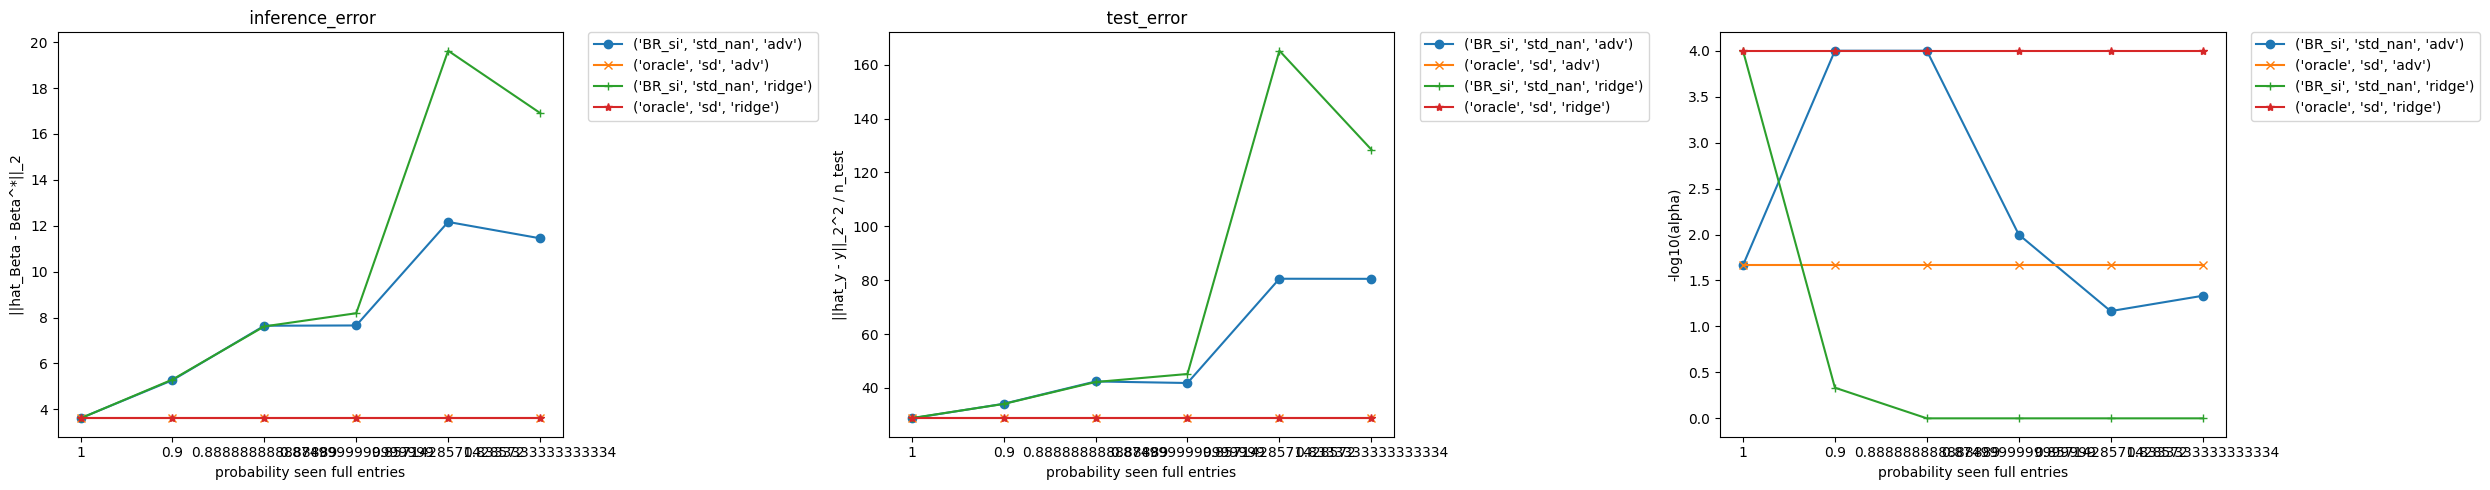

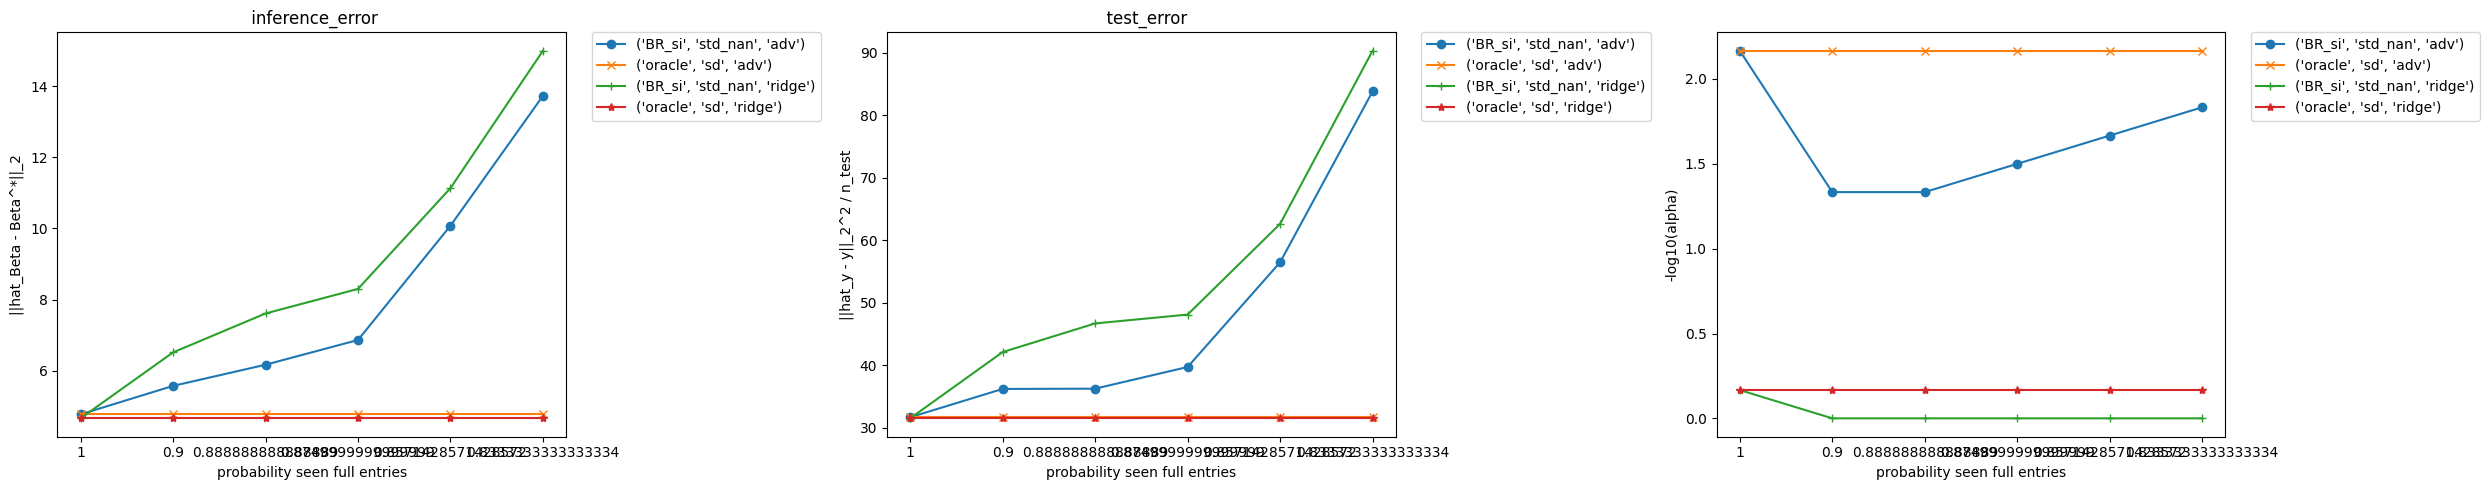

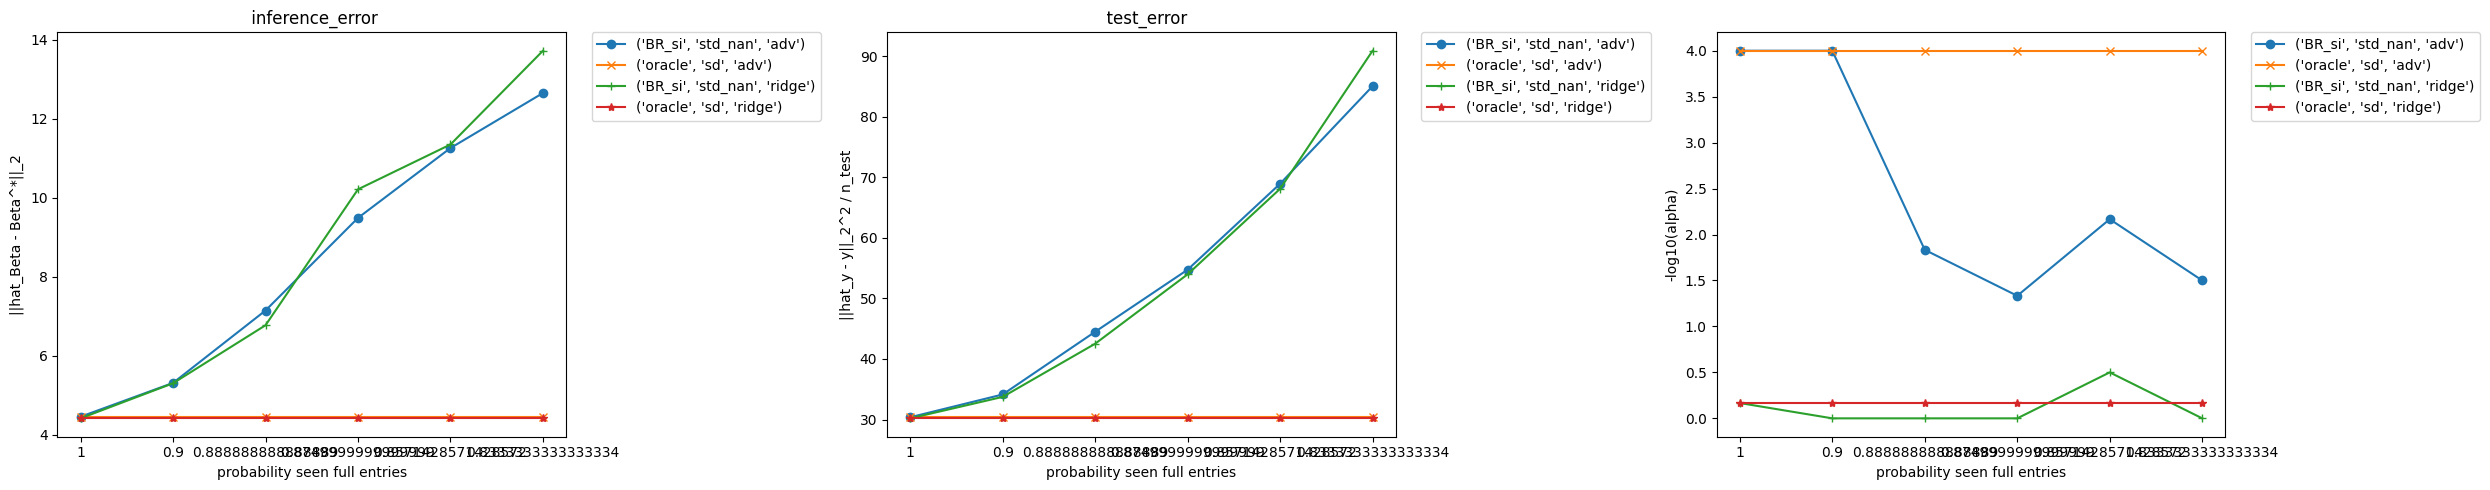

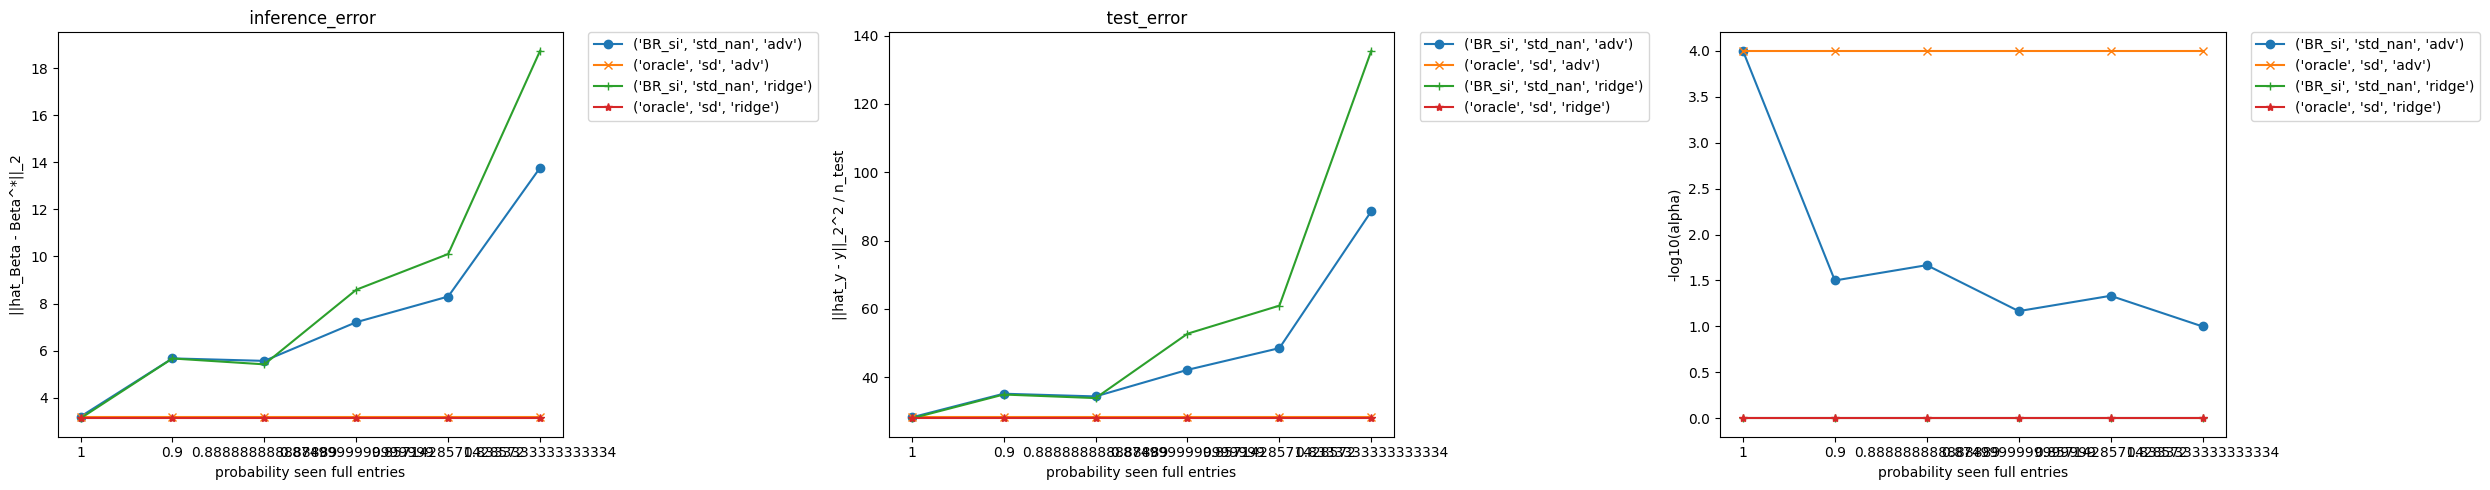

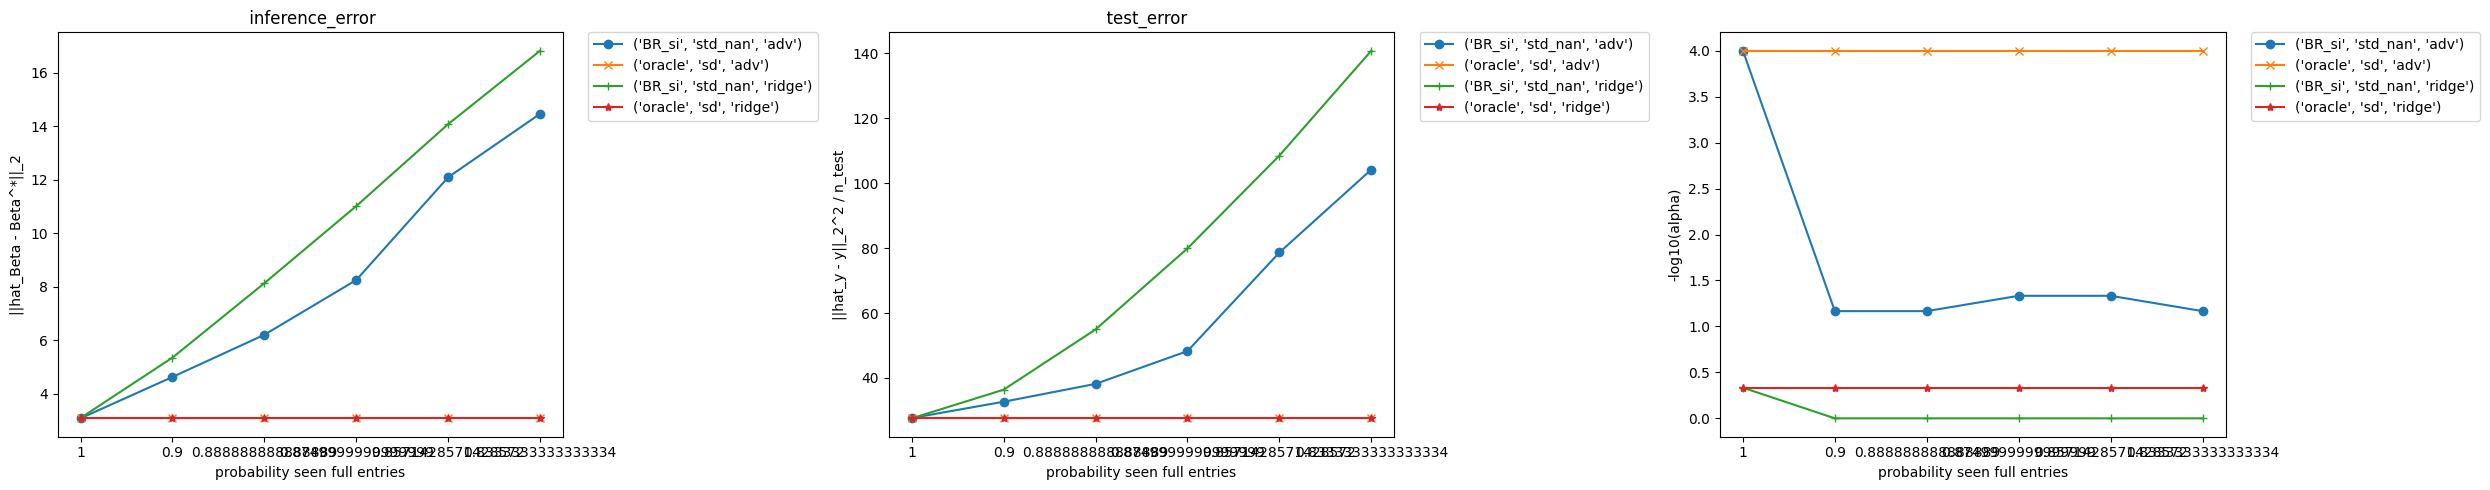

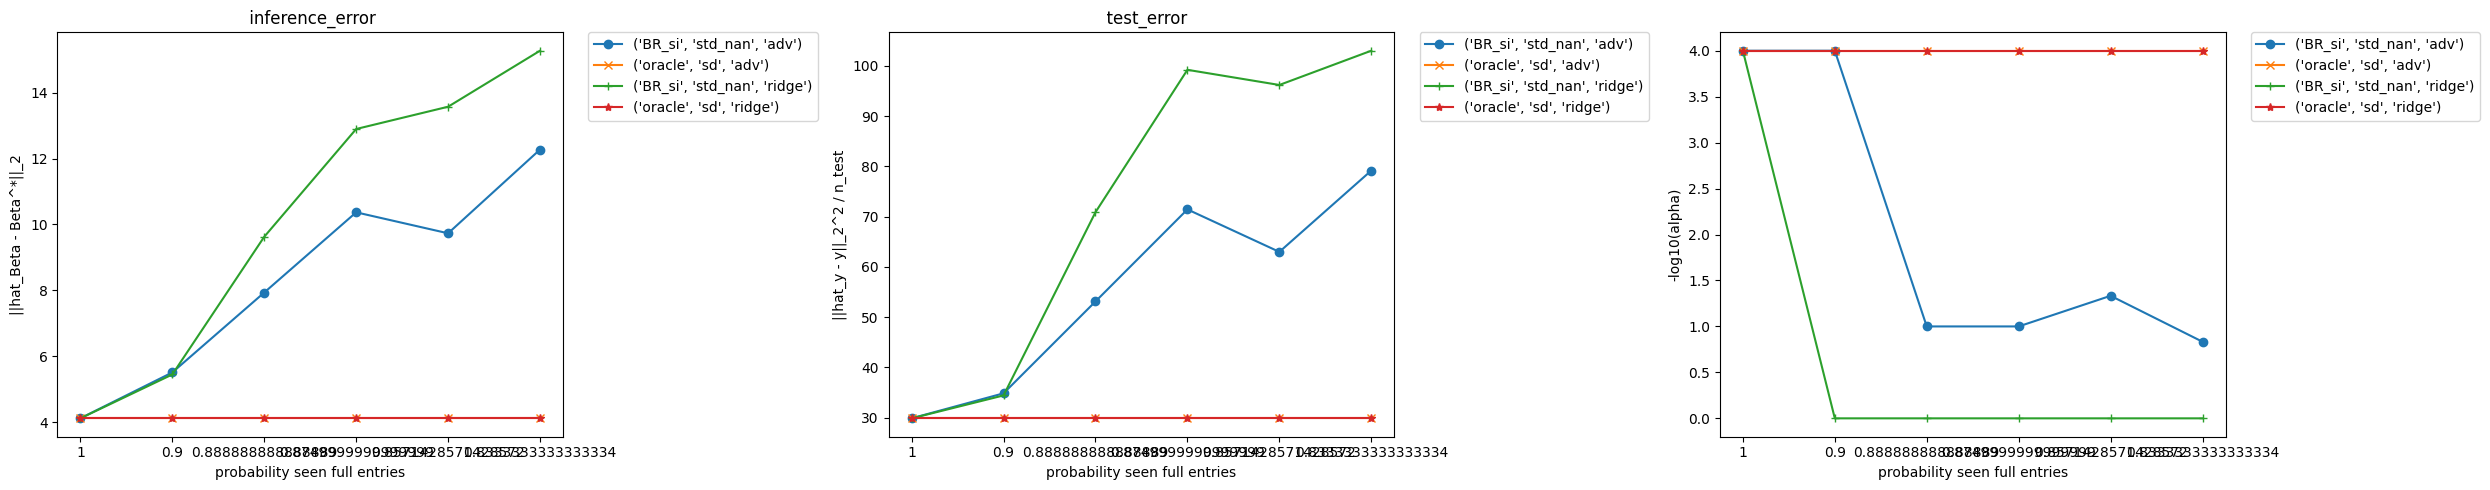

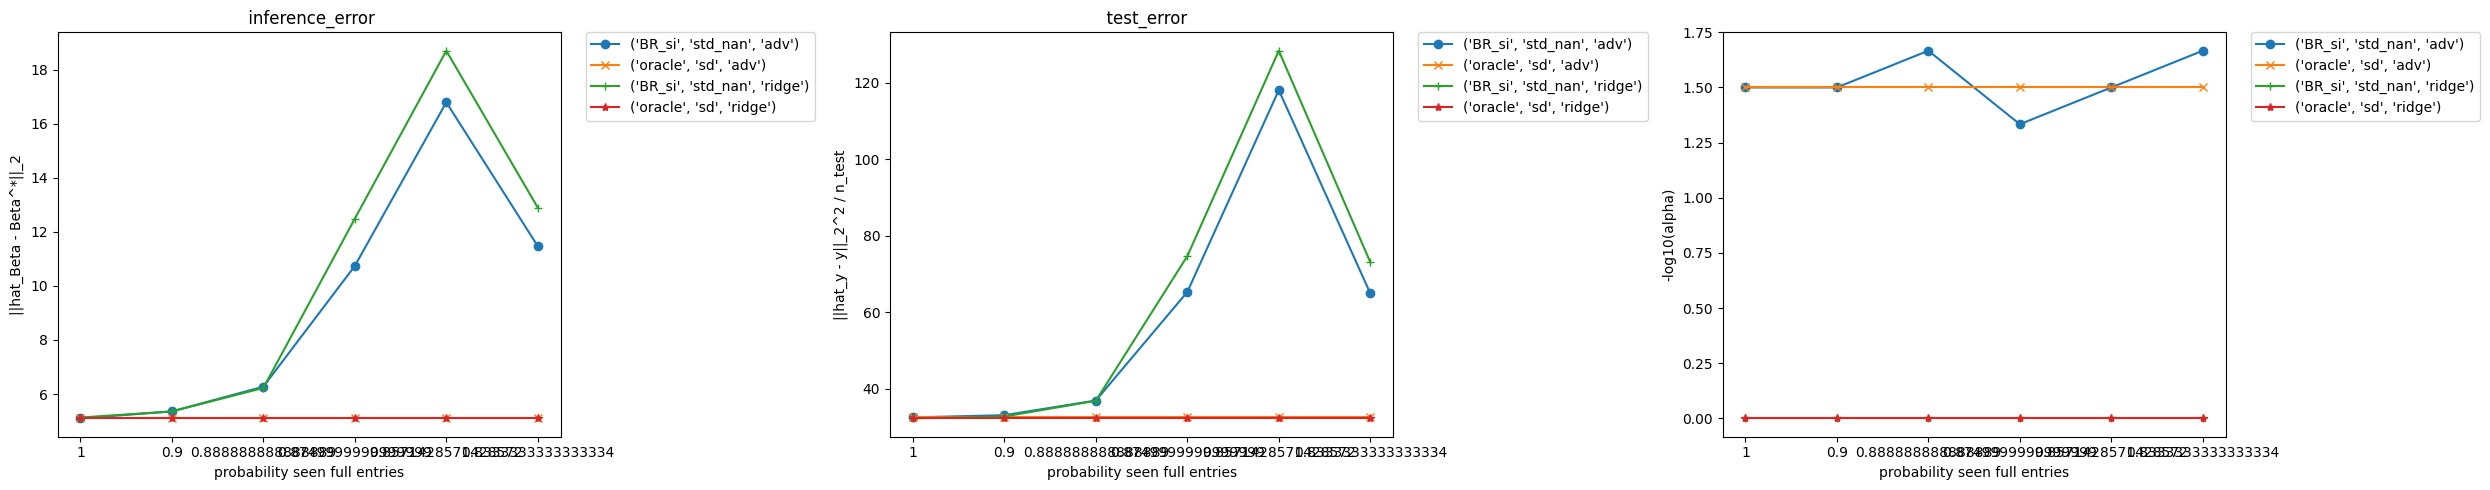

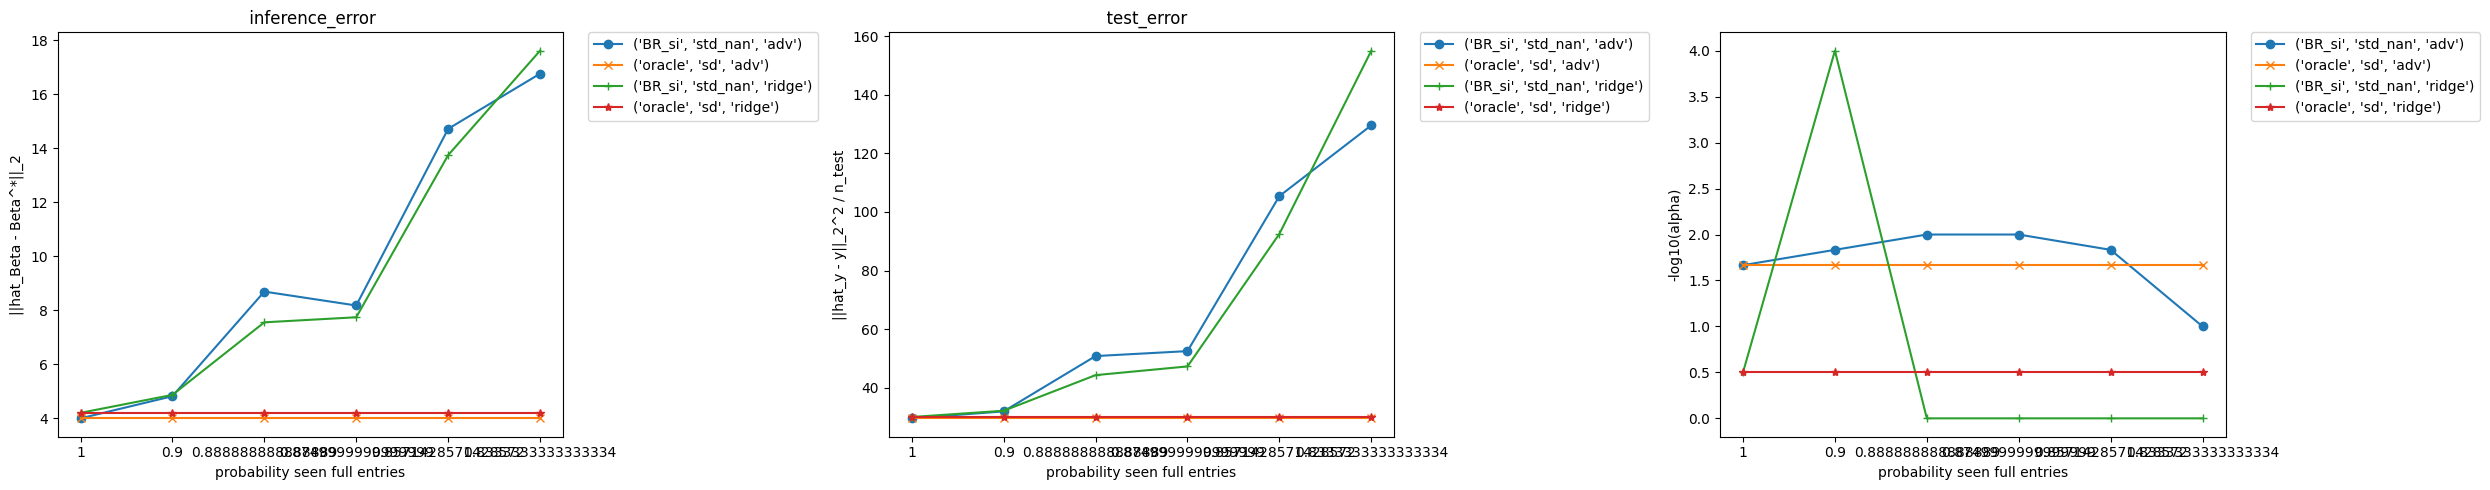

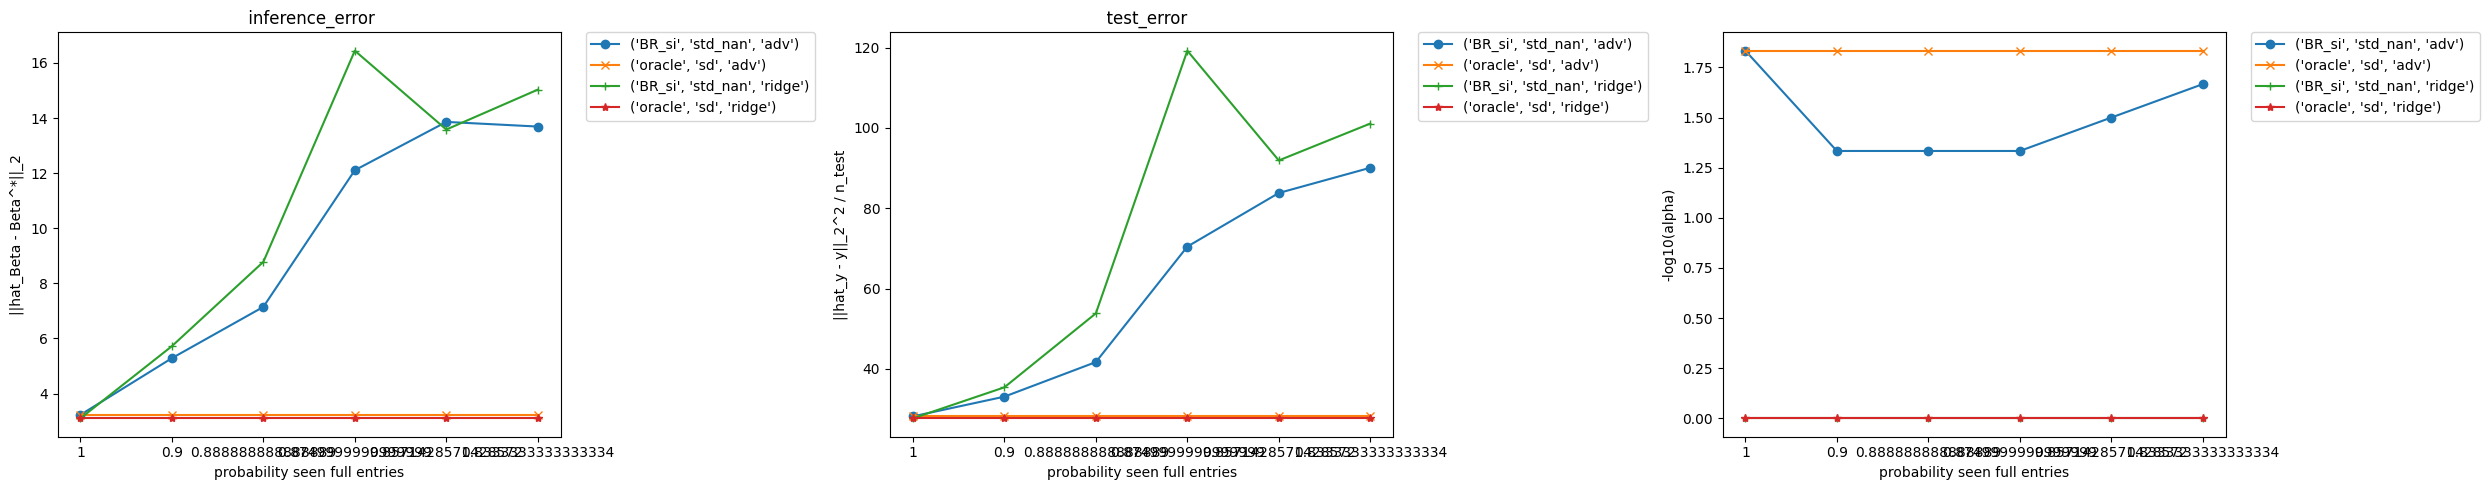

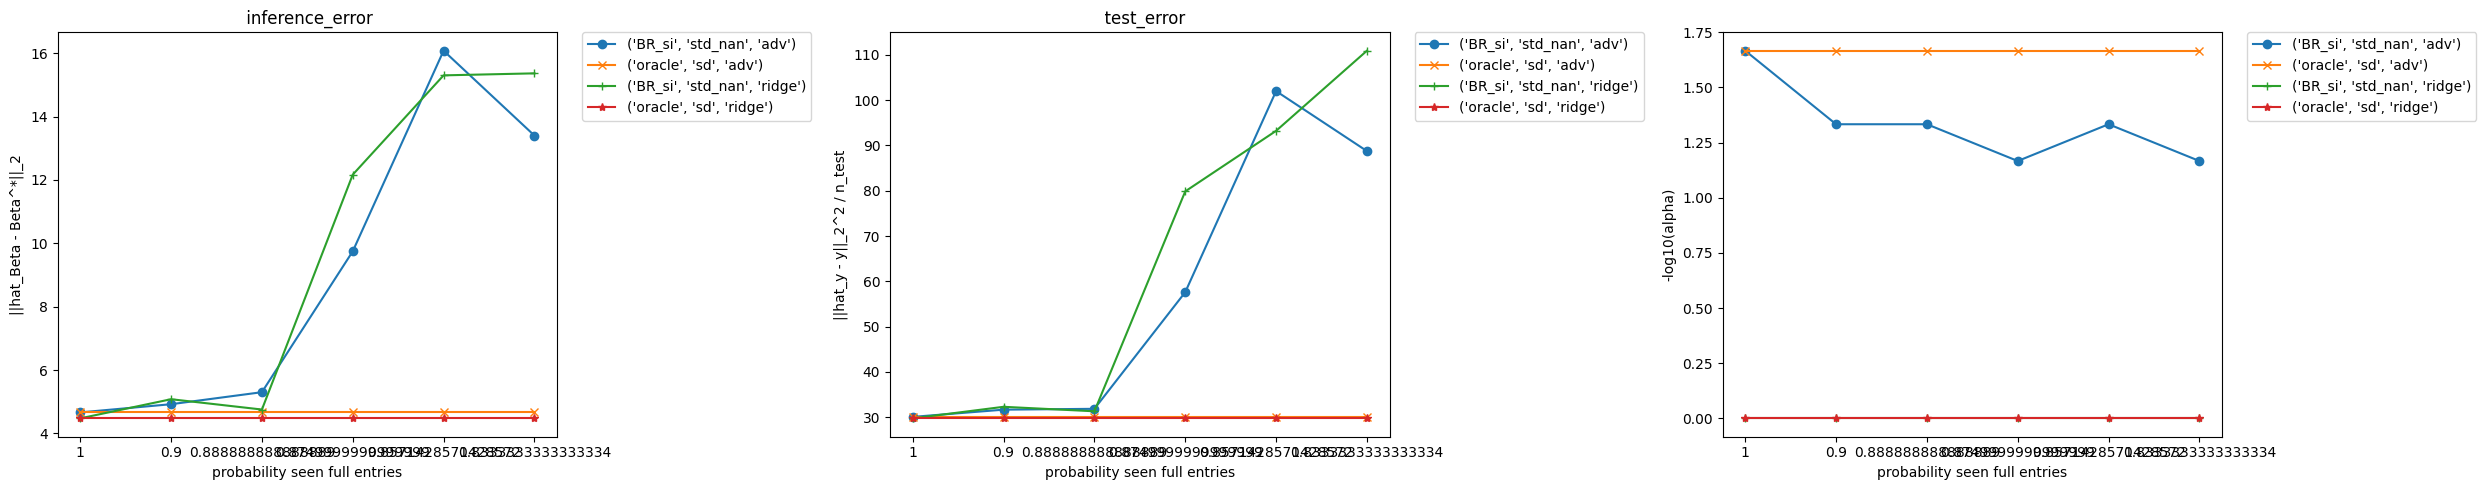

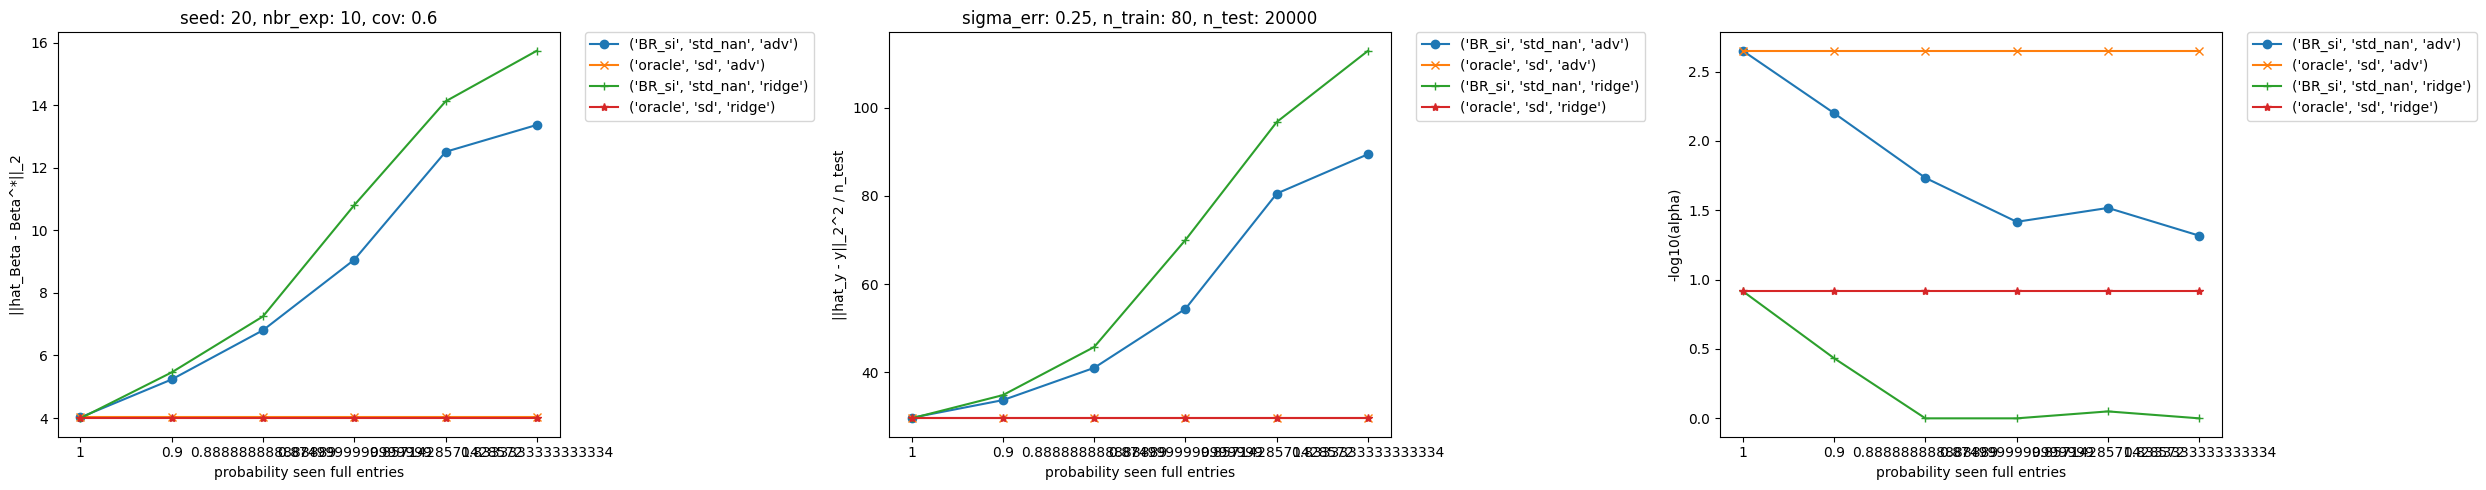

In [24]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [80] * length_vec
error_vec =  [0.25] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 0.1
cov = matr.T @ matr + np.eye(dim) * 0.25
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 1,
                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 10
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 20
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 0 0 0]
  [0 0 1 0]]]
[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 1 1 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 1 1 1]
  [0 0 2 0]]]
[[[0 0 0 0]
  [0 0 0 0]
  [0 1 1 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 1 1 1]
  [0 0 1 0]]

 [[0 0 0 0]
  [0 0 0 1]
  [0 1 1 1]
  [0 0 1 0]]]
[[2 3 1 2]
 [2 1 3 1]
 [1 3 2 1]]
[[[2. 0. 0. 0.]
  [0. 3. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 2.]]

 [[2. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 3. 0.]
  [0. 0. 0. 1.]]

 [[1. 0. 0. 0.]
  [0. 3. 0. 0.]
  [0. 0. 2. 0.]
  [0. 0. 0. 1.]]]


In [30]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)






coef :  [ 1.99234884 -0.99981871 -0.01555797 -0.01290579]
coef :  [ 1.99233051 -0.99981168 -0.01555649 -0.01290386]
coef :  [ 1.99049891 -0.99910915 -0.01540842 -0.01271124]
coef :  [ 1.97400571 -0.992763   -0.01409143 -0.01099221]
